In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator
from scipy.spatial import Delaunay
import sys
import os
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm

In [2]:
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))

class Interp2DInDomain:
    def __init__(self,points,vals,isInDomainF,kind='cubic'):
        if kind == 'cubic':
            self.interpF = CloughTocher2DInterpolator(points,vals)
        elif kind == 'linear':
            self.interpF = LinearNDInterpolator(points,vals)
        else:
            raise ValueError("kind must be either 'cubic' or 'linear'")
        self.inInDomainF = isInDomainF
        self.nDims = vals.shape[-1]
    
    def __call__(self,points):
        vals = self.interpF(points)
        vals[~self.inInDomainF(points)] = np.nan
        return vals
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
def addInterpF2Data(data,derL=False,includePressureBC=False):
    valSliceE = slice(0,3)
    valSliceD = slice(0,2)

    data['isInDomainF'] = IsInDomain(data['nodesCurves'])
    # data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'],kind='linear')
    # data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'],kind='linear')
    data['interpSE'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceE],data['isInDomainF'],kind='cubic')
    data['interpSD'] = Interp2DInDomain(data['nodes'],data['solution'][:,valSliceD],data['isInDomainF'],kind='cubic')
    data['interpD2B'] = Interp2DInDomain(data['nodes'],data['distance2boundary'],data['isInDomainF'],kind='linear')
    data['interpELS'] = Interp2DInDomain(data['nodes'],data['elSizeNodes'],data['isInDomainF'],kind='linear')

    data['solutionB'] = []
    data['interpBS'] = []
    data['interpBN'] = []
    data['interpBC'] = []
    if derL:
        data['solutionBoffset'] = []
        
    for i in range(len(data['idxCurves'])):
        data['solutionB'].append(data['solution'][data['idxCurves'][i]])

        if derL:
            nodesCurvesOffset = data['nodesCurves'][i] - derL*data['normalCurves'][i]
            valsCurvesOffset = data['interpSE'](nodesCurvesOffset)
            data['solutionBoffset'].append(valsCurvesOffset)
            boundaryData = np.concatenate([data['solutionB'][i],valsCurvesOffset],-1)
            data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],boundaryData))
        else:
            if includePressureBC:
                data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i]))
            else:
                data['interpBS'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['solutionB'][i][:,:2]))
        
        data['interpBN'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['normalCurves'][i]))
        data['interpBC'].append(Interp1DPchipPeriodic(data['distanceCurves'][i],data['nodesCurves'][i]))

def addElementSize2Data(data):
    nodes = data['nodes']
    elements = data['elements']
    areaElements = GetAreaTriang(nodes[elements])[:,0,0]
    areaNodes = np.zeros(nodes.shape[0])
    countNodes = np.zeros(nodes.shape[0])
    for i,el in enumerate(elements):
        areaNodes[el] += areaElements[i]
        countNodes[el] += 1

    countNodes[countNodes == 0] = np.inf
    areaNodes /= countNodes
    areaNodes = areaNodes.reshape(-1,1)
    elSizeNodes = 2/(3**0.25)*np.sqrt(areaNodes)
    data['elSizeNodes'] = elSizeNodes

def remove_elements(lst, indices):
    for index in sorted(indices, reverse=True):
        if index < len(lst):
            del lst[index]
    return lst

def loadData(filePath,derL=False,includePressureBC=False):
    with open(filePath, 'r') as f:
        data = json.load(f)
    
    idxIgnore = [293, 369, 564, 1561, 1867, 1998, 2473, 2475, 2802, 3272, 3469, 3474, 3594, 3764, 3784, 3900, 3921]
    data = remove_elements(data,idxIgnore)
    keys_single = ['nodes', 'elements', 'solution', 'elementsBoundaryNodesOnly','areaElementsBoundaryNodesOnly','distance2boundary','elSizeNodes']
    for i in tqdm(range(len(data))):
        for key in data[i].keys():
            if key in keys_single:
                data[i][key] = np.array(data[i][key])
            else:
                for j in range(len(data[i][key])):
                    if type(data[i][key][j]) == list:
                        data[i][key][j] = np.array(data[i][key][j])
        # try:
        #     addInterpF2Data(data[i],derL)
        # except:
        #     print('Error in data',i)
        #     idxIgnore.append(i)
        #     continue
        addInterpF2Data(data[i],derL,includePressureBC)
        data[i]['area'] = GetAreaTriang(data[i]['nodes'][data[i]['elements']])
    return data

def GenerateGeometry2(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    
    for i in range(4):
        g.line([i,(i+1)%4],marker=1)
    g.spline(list(range(4,p.shape[0]))+[4],marker=2)
    g.surface([0,1,2,3],[[4]])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = [np.array(bdofs[1])-1,np.array(bdofs[2])-1]
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), np.concatenate(boundaryNodes))
    return nodes, elements, boundaryNodes, internalNodes

def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def RemeshData(data,elSize):
    nodes = data['nodes']
    idxSquare = data['idxCorner']
    idxSpline = data['idxCurves'][1][:-1]
    nodesB = np.concatenate([ nodes[idxSquare], nodes[idxSpline]],0)

    g = GenerateGeometry2(nodesB)
    nodes,elements,idxCurves,internalNodes = MeshSurface(g,elSize)
    for i in range(len(idxCurves)):
        idxCurves[i] = np.sort(idxCurves[i])

    nodesCurve00 = nodes[idxCurves[0][0]]
    alpha0 = np.arctan2(nodesCurve00[1],nodesCurve00[0])
    nodesCurves0 = nodes[idxCurves[0]]
    alpha = np.arctan2(nodesCurves0[:,1],nodesCurves0[:,0])-alpha0
    alpha[alpha<0] += 2*np.pi
    idxs_sorted = np.argsort(alpha)
    idxCurves[0] = idxCurves[0][idxs_sorted]
    for i in range(len(idxCurves)):
        idxCurves[i] = np.concatenate([idxCurves[i],idxCurves[i][0:1]],0)

    nodesCurves = [nodes[idxCurves[i]] for i in range(len(idxCurves))]
    distanceCurves = [computeLengthAlongCurve(nodesCurves[i]) for i in range(len(idxCurves))]
    lengthCurves = [distanceCurves[i][-1] for i in range(len(idxCurves))]

    solution = data['interpSE'](nodes)[:,:2]
    for i in range(len(idxCurves)):
        solution[idxCurves[i][:-1]] =  data['interpBS'][i](distanceCurves[i][:-1])[:,:2]
    curvesNormals = [data['interpBN'][i](distanceCurves[i]) for i in range(len(idxCurves))]


    data_remeshed = {'nodes':nodes, 'elements':elements, 'idxCurves':idxCurves, 'internalNodes':internalNodes, \
                     'nodesCurves':nodesCurves, 'distanceCurves':distanceCurves, 'lengthCurves':lengthCurves, \
                     'solution':solution, 'curvesNormals':curvesNormals, 'interpSE':data['interpSE'], 'interpSD':data['interpSD'], \
                     'interpBS':data['interpBS'], 'interpBN':data['interpBN'], 'interpBC':data['interpBC'], 'isInDomainF':data['isInDomainF']}

    return data_remeshed

def GetAreaTriang(nodes_els):
    # Calculate the area of a triangles in a mesh
    #   nodes_els - [N,3,2] tensor which containes the x,y positions of nodes of N triangles
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    return Area

def GenerateTriangTrainMeshInter(sRand=0.1):
    # Generates random variation of a mesh made out of 6 triangular elements in a hexagon configuration
    # The mesh is normalized so that the longest edge length is 1
    #   nodes - [7,2] tensor which containes the x,y positions of nodes of the mesh
    #   elements - [6,3] tensor which containes the indices of the nodes of the mesh

    # constructu a hexagon with a point in the middle
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3 + np.random.uniform(-np.pi/15,np.pi/15,6)
    r = np.random.uniform(1-sRand,1+sRand,6)
    bNodes = np.stack([np.cos(alphas)*r,np.sin(alphas)*r],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)

    # construct element matrix
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1

    # randomly rotate the mesh
    rot = np.random.uniform(0,np.pi/3)
    rot_mat = np.array([[np.cos(rot),np.sin(rot)],[-np.sin(rot),np.cos(rot)]])
    nodes = (rot_mat@nodes.T).T
    return nodes,elements

def RandomTriangSample(nodes):
    # Sample a random points inside a trinagle defined by [3,2] matrix: nodes
    y = np.random.uniform()
    x = np.abs(np.random.uniform()-np.random.uniform())
    p = nodes[1] + (nodes[0]-nodes[1])*x - (nodes[1]-nodes[2])*(1-x)*y
    return p

def RandomMeshSample(nodes,elements,Area):
    # Sample a random point from a 2D shape defined with a mesh: (nodes, elements)
    el_sample = np.random.choice(np.arange(elements.shape[0]),p=Area.flatten()/Area.sum())
    point_sample = RandomTriangSample(nodes[elements[el_sample]])
    return point_sample

# def GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,interpD2B,elSizeMin=0.04,elSizeMax=0.07,sRand=0.1):
#     # Get a random interior training patch mesh from a mesh defined by (nodes, elements, boundaryNodes)
#     # The mesh will be scaled so that the longest edge is approximately between elSizeMin and elSizeMax
#     # In case the randomly sampled point is so close to the boundary that the Training Patch mesh does not fit fully inside the domain the point is resampled
#     iterations = 0
#     while (iterations < 1_000):
#         samplePoint = RandomMeshSample(nodes,elements,areaElements)
#         notesTP, elementsTP = GenerateTriangTrainMeshInter(sRand)
#         elSize = np.random.uniform(elSizeMin, elSizeMax)
#         if interpD2B(samplePoint.reshape(-1,2)) < elSize*1.5:
#             iterations += 1
#             continue
#         nodesTP = notesTP * elSize + samplePoint.reshape(1,2)
#         isInDomain = isInDomainF(nodesTP)
#         if np.all(isInDomain):
#             break
#         iterations += 1
#     return nodesTP, elementsTP

def GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,interpD2B,elSizeMin=0.04,elSizeMax=0.07,elSizeF=None,sRand=0.1):
    # Get a random interior training patch mesh from a mesh defined by (nodes, elements, boundaryNodes)
    # The mesh will be scaled so that the longest edge is approximately between elSizeMin and elSizeMax
    # In case the randomly sampled point is so close to the boundary that the Training Patch mesh does not fit fully inside the domain the point is resampled
    iterations = 0
    while (iterations < 1_000):
        samplePoint = RandomMeshSample(nodes,elements,areaElements).reshape(-1,2)
        notesTP, elementsTP = GenerateTriangTrainMeshInter(sRand)
        if elSizeF is None:
            elSize = np.random.uniform(elSizeMin, elSizeMax)
        else:
            elSize = elSizeF(samplePoint) * np.random.uniform(elSizeMin, elSizeMax)
        if interpD2B(samplePoint) < elSize*1.6:
            iterations += 1
            continue
        nodesTP = notesTP * elSize + samplePoint
        isInDomain = isInDomainF(nodesTP)
        if np.all(isInDomain):
            break
        iterations += 1
    return nodesTP, elementsTP

# Defined the points of the encoder input mask
def GetRadialEncoderInputMask(n_r,n_theta,k=0.5,Esize=0.05):
    # Get Radial interior encoder input mask
    #   n_theta - number of radial directions along which points are defined
    #   n_r - number of points along each radial direction
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - size of the interour encoder mask, radius of the circle
    alphas = np.linspace(0,2*np.pi,n_theta+1)[:-1].reshape(1,-1)
    r = np.linspace(0,1,n_r+1)[1:].reshape(-1,1)
    r = k*r+(1-k)*r**3
    nodesIE = np.stack([r*np.cos(alphas),r*np.sin(alphas)],axis=-1)
    nodesIE = np.concatenate([[[0,0]],nodesIE.reshape(-1,2)],axis=0)
    return nodesIE*Esize

def GetSquareEncoderInputMask(n,k=0.5,Esize=0.05):
    # Get Square interior encoder input mask
    #   The mask is a 2n x 2n grid points of size 2*Esize x 2*Esize (in x,y coordinates)
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    x = np.linspace(-1,1,2*n+1)
    x = k*x+(1-k)*x**3
    X,Y = np.meshgrid(x,x)
    nodesIE = np.stack([X,Y],axis=-1).reshape(-1,2)
    return nodesIE*Esize

def GetBoundaryEncoderInputMask(n,k,Esize=0.05):
    # Get boundary encoder input mask whcih is defined along the boundary
    #   total number of points in teh boundary encoder input mask is 2*n-1
    #   k - coefficient between 0 and 1 which defines how much should the points be denser towards the centre compared to the edge
    #   Esize - the size of the  boundary encoder input mask, the length of the mask is 2*Esize
    x = np.linspace(-1,1,2*n-1)
    x = (k*np.abs(x)+(1-k)*np.abs(x)**2) * np.sign(x)
    return x*Esize

def GetEncoderInputTP(nodesTP,nodesIE):
    # Based on training patch mesh nodes (nodesTP) and nodes of the interior encoder input mask (nodesIE) generates all interior encoder input mask points within the training patch
    nodesTP = nodesTP.reshape(-1,1,2)
    nodesIE = nodesIE.reshape(1,-1,2)
    nodesTP_IE = nodesTP + nodesIE
    return nodesTP_IE

def GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False,sRand=0.1,variableElSize=False):
    # Samples a random training patch from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   nodesD - decoder output mask nodes
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodes = data[idx]['nodes']
    # if variableElSize:
    #     elements = data[idx]['elements']
    #     areaElements = np.ones(elements.shape[0])
    # else:
    elements = data[idx]['elementsBoundaryNodesOnly']
    areaElements = data[idx]['areaElementsBoundaryNodesOnly']
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    isInDomainF = data[idx]['isInDomainF']
    interpD2B = data[idx]['interpD2B']
    if variableElSize:
        interpELS = data[idx]['interpELS']
    else:
        interpELS = None

    # nodesTP, elementsTP = GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,elSizeMin,elSizeMax,sRand=sRand) # get training patch mesh
    nodesTP, elementsTP = GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,interpD2B,elSizeMin=elSizeMin,elSizeMax=elSizeMax,elSizeF=interpELS,sRand=sRand)
    nodesTP_IE = GetEncoderInputTP(nodesTP,nodesIE) # get all nodes of the training patch
    uTP_IE = interpSE(nodesTP_IE.reshape(-1,2)).reshape(7,nodesIE.shape[0],-1) # sample solution at training patch nodes
    bTP_IE = isInDomainF(nodesTP_IE.reshape(-1,2)).reshape(7,nodesIE.shape[0]) # sample boundary mask for interior econder input (1 if inside the domain, 0 if outside)
    uTP_IE[~bTP_IE] = 0 # set solution values outside of the domain to 0
    bTP_IE = np.expand_dims(bTP_IE,-1)

    nodesTP_D = nodesD+nodesTP[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        return nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, nodesTP_IE
    else:
        return nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GenerateTriangTrainMeshBoundary(v_rand = 0.1):
    # Generates a mesh of 6 triangular elements in a hexagon configuration where the two bottom points have x,y coordinates (0,0) and (1,0)
    alphas = np.linspace(0,2*np.pi,7)[:-1]-2*np.pi/3
    bNodes = np.stack([np.cos(alphas),np.sin(alphas)],axis=1)
    nodes = np.concatenate([[[0,0]],bNodes],axis=0)
    # randomly perturb the nodes except the two bottom ones
    v_rand_nodes = np.random.uniform(-v_rand,v_rand,(7,2))
    v_rand_nodes[[1,2],:] = 0
    nodes += v_rand_nodes
    nodes = nodes-nodes[1]
    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    return nodes,elements

# def GetRandomTPmeshBoundary(nodesB,length,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,idx_curve_0=None,distance_0=None):
#     # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
#     #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

#     length = np.array(length)
#     if idx_curve_0 is None:
#         idx_curve_0 = np.random.choice(np.arange(len(nodesB)),p=length/length.sum())
#         # idx_curve_0 = np.random.randint(0,len(nodesB))
#     if distance_0 is None:
#         distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

#     iterations = 0

#     while iterations < 1_000:

#         elSize = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh

#         scale = 1 # scaling factor elSize which is used to fite the training patch mesh in areas of high boundary curvature were distance is not a good measure of the element size
#         for i in range(100):
#             # iterate to find the second point of the training patch mesh on the boundary
#             distance_1 = (distance_0 + elSize*scale)#%length[idx_curve_0] # define the second point of the training patch mesh on the boundary

#             # interpolate the boundary nodes between the two sampled points
#             nodes_0 = interpNodesB[idx_curve_0](distance_0)
#             nodes_1 = interpNodesB[idx_curve_0](distance_1)

#             # Computes the appropriate scaling and rotation for the normalized training patch mesh
#             rotTPB = -np.arctan2(nodes_1[1]-nodes_0[1],nodes_1[0]-nodes_0[0])
#             elSizeTPB = np.sqrt(((nodes_1 - nodes_0)**2).sum())
#             if abs(elSizeTPB-elSize)/elSize < 0.1:
#                 break
            
#             scale = scale*np.sqrt(elSize/elSizeTPB)

#         rot_mat = np.array([[np.cos(rotTPB),np.sin(rotTPB)],[-np.sin(rotTPB),np.cos(rotTPB)]])
#         nodesTPB, elementsTPB = GenerateTriangTrainMeshBoundary()
#         nodesTPB = (rot_mat@nodesTPB.T).T * elSizeTPB + nodes_0
#         isInDomain = IsInDomainF(nodesTPB[[0,3,4,5,6]])
        
#         # Check if the training patch mesh is within the domain and the element size is within the bounds
#         if np.all(isInDomain) and (elSizeTPB < elSizeMax) and (elSizeTPB > elSizeMin):
#             break
#         iterations += 1
#         distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

#     # print(iterations)
#     return nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0

def GetRandomTPmeshBoundary(nodesB,length,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,elSizeBF=None,idx_curve_0=None,distance_0=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

    length = np.array(length)
    if idx_curve_0 is None:
        # idx_curve_0 = np.random.choice(np.arange(len(nodesB)),p=length/length.sum())
        idx_curve_0 = np.random.randint(0,len(nodesB))
    if distance_0 is None:
        distance_0 = np.random.uniform(0,length[idx_curve_0]) # randomly sample a point on the boundary

    iterations = 0

    while iterations < 1_000:

        if elSizeBF is None:
            elSize = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh
        else:
            elSize = elSizeBF[idx_curve_0](distance_0) #* np.random.uniform(elSizeMin,elSizeMax)

        scale = 1 # scaling factor elSize which is used to fite the training patch mesh in areas of high boundary curvature were distance is not a good measure of the element size
        for i in range(100):
            # iterate to find the second point of the training patch mesh on the boundary
            distance_1 = (distance_0 + elSize*scale) # define the second point of the training patch mesh on the boundary

            # interpolate the boundary nodes between the two sampled points
            nodes_0 = interpNodesB[idx_curve_0](distance_0)
            nodes_1 = interpNodesB[idx_curve_0](distance_1)

            # Computes the appropriate scaling and rotation for the normalized training patch mesh
            rotTPB = -np.arctan2(nodes_1[1]-nodes_0[1],nodes_1[0]-nodes_0[0])
            elSizeTPB = np.sqrt(((nodes_1 - nodes_0)**2).sum())
            if abs(elSizeTPB-elSize)/elSize < 0.1:
                break
            
            scale = scale*np.sqrt(elSize/elSizeTPB)

        rot_mat = np.array([[np.cos(rotTPB),np.sin(rotTPB)],[-np.sin(rotTPB),np.cos(rotTPB)]])
        nodesTPB, elementsTPB = GenerateTriangTrainMeshBoundary()
        nodesTPB = (rot_mat@nodesTPB.T).T * elSizeTPB + nodes_0
        isInDomain = IsInDomainF(nodesTPB[[0,3,4,5,6]])
        
        # Check if the training patch mesh is within the domain and the element size is within the bounds
        if np.all(isInDomain):
            break
        iterations += 1
        distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

    return nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0


def GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07, elSizeBF=None, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodesB = data[idx]['nodesCurves']
    lengthCurves = data[idx]['lengthCurves']
    interpNodesB = data[idx]['interpBC']
    isInDomainF = data[idx]['isInDomainF']
    if elSizeBF is not None:
        elSizeBF = [lambda x: 0.3, lambda x: 0.01]

    # Get random training patch mesh
    # nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0 = GetRandomTPmeshBoundary(nodesB,lengthCurves,interpNodesB,isInDomainF,elSizeMin,elSizeMax)
    nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0 = GetRandomTPmeshBoundary(nodesB,lengthCurves,interpNodesB,isInDomainF,elSizeMin=elSizeMin,elSizeMax=elSizeMax,elSizeBF=elSizeBF)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve_0]
    interpBN = data[idx]['interpBN'][idx_curve_0]

    nodesTP_BEi = GetEncoderInputTP(nodesTPB[[0,3,4,5,6]],nodesIE) # get nodes for the interour encoder input
    uTP_BEi = interpSE(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1],-1)
    bTP_BEi = isInDomainF(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1])
    uTP_BEi[~bTP_BEi] = 0
    bTP_BEi = np.expand_dims(bTP_BEi,-1)
    distanceTP_BEb = np.array([[distance_0],[distance_1]])+distanceBE # get alpha for the boundary encoder input
    uTP_BEb = interpBS(distanceTP_BEb)
    normalTP_BEb = interpBN(distanceTP_BEb)

    nodesTP_D = nodesD+nodesTPB[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve_0]
        nodesTP_BEb = interpBC(distanceTP_BEb)
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb
    else:
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07,sRand=0.1):
    for i in range(batch_size*n_batches):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax,sRand=sRand)
        nodesTP = tf.convert_to_tensor(nodesTP, dtype=tf.float32)
        elementsTP = tf.convert_to_tensor(elementsTP, dtype=tf.int32)
        uTP_IE = tf.convert_to_tensor(uTP_IE, dtype=tf.float32)
        bTP_IE = tf.convert_to_tensor(bTP_IE, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D

def GetInteriorDataset(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interpSE'].nDims
    d_D = data[0]['interpSD'].nDims
    dataset = tf.data.Dataset.from_generator(
        lambda: InteriorDatasetGenerator(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([7,nodesIE.shape[0],d_IE]), tf.TensorShape([7,nodesIE.shape[0],1]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetInteriorDatasetFixed(data, nodesIE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07,sRand=0.1,variableElSize=False):
    d_IE = data[0]['interpSE'].nDims
    d_D = data[0]['interpSD'].nDims
    dataset_tesor_nodesTP = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTP = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_IE = np.zeros((batch_size*n_batches, 7, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = GetRandomTrainingPatchInternal(data, nodesIE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax,sRand=sRand,variableElSize=variableElSize)
        dataset_tesor_nodesTP[i] = nodesTP
        dataset_tesor_elementsTP[i] = elementsTP
        dataset_tesor_uTP_IE[i] = uTP_IE
        dataset_tesor_bTP_IE[i] = bTP_IE
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D
    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTP, dataset_tesor_elementsTP, 
                                                  dataset_tesor_uTP_IE, dataset_tesor_bTP_IE, 
                                                  dataset_tesor_u_D, dataset_tesor_b_D))

    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def BoundaryDatasetGenerator(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07, elSizeBF=None):
    for i in range(batch_size*n_batches):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax, elSizeBF=elSizeBF)
        nodesTPB = tf.convert_to_tensor(nodesTPB, dtype=tf.float32)
        elementsTPB = tf.convert_to_tensor(elementsTPB, dtype=tf.int32)
        uTP_BEi = tf.convert_to_tensor(uTP_BEi, dtype=tf.float32)
        bTP_BEi = tf.convert_to_tensor(bTP_BEi, dtype=tf.float32)
        uTP_BEb = tf.convert_to_tensor(uTP_BEb, dtype=tf.float32)
        normalTP_BEb = tf.convert_to_tensor(normalTP_BEb, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D

def GetBoundaryDataset(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interpSE'].nDims
    d_BE = data[0]['interpBS'][0].spline.c.shape[-1]
    d_D = data[0]['interpSD'].nDims

    dataset = tf.data.Dataset.from_generator(
        lambda: BoundaryDatasetGenerator(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([5,nodesIE.shape[0],d_IE]), tf.TensorShape([5,nodesIE.shape[0],1]), 
                       tf.TensorShape([2,distanceBE.shape[0],d_BE]), tf.TensorShape([2,distanceBE.shape[0],2]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetBoundaryDatasetFixed(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07, elSizeBF=None):
    d_IE = data[0]['interpSE'].nDims
    d_BE = data[0]['interpBS'][0].spline.c.shape[-1]
    d_D = data[0]['interpSD'].nDims

    dataset_tesor_nodesTPB = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTPB = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_BEi = np.zeros((batch_size*n_batches, 5, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_uTP_BEb = np.zeros((batch_size*n_batches, 2, distanceBE.shape[0], d_BE),dtype=np.float32)
    dataset_tesor_normalTP_BEb = np.zeros((batch_size*n_batches, 2, distanceBE.shape[0], 2),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=elSizeMin, elSizeMax=elSizeMax, elSizeBF=elSizeBF)
        dataset_tesor_nodesTPB[i] = nodesTPB
        dataset_tesor_elementsTPB[i] = elementsTPB
        dataset_tesor_uTP_BEi[i] = uTP_BEi
        dataset_tesor_bTP_BEi[i] = bTP_BEi
        dataset_tesor_uTP_BEb[i] = uTP_BEb
        dataset_tesor_normalTP_BEb[i] = normalTP_BEb
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D

    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTPB, dataset_tesor_elementsTPB,
                                                    dataset_tesor_uTP_BEi, dataset_tesor_bTP_BEi,
                                                    dataset_tesor_uTP_BEb, dataset_tesor_normalTP_BEb,
                                                    dataset_tesor_u_D, dataset_tesor_b_D))
    
    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GenerateTriangTrainMeshCorner(v_rand = 0.1):
    # Generates a mesh of 6 triangular elements in a hexagon configuration where the 3 nodes in the left bottom corner have coordinates (0,1), (0,0) and (1,0)
    sqrt_2 = np.sqrt(2)
    nodes = np.array([[(sqrt_2+1)/(2*sqrt_2), (sqrt_2+1)/(2*sqrt_2)],
                      [0,0],
                      [1,0],
                      [1+1/sqrt_2,1/sqrt_2],
                      [1+1/sqrt_2,1+1/sqrt_2],
                      [1/sqrt_2,1+1/sqrt_2],
                      [0,1]])
    
    nodes[[0,3,4,5]] += np.random.uniform(-v_rand,v_rand,(4,2))

    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    return nodes,elements

def GetRandomTPmeshCorner(distaceCornerCurve,idxCurveCorner,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,sRand=0.1,idx_corner=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

    if idx_corner is None:
        idx_corner = np.random.randint(0,len(distaceCornerCurve))
    
    idx_curve = idxCurveCorner[idx_corner]
    distance_1 = distaceCornerCurve[idx_corner] # distance along the boundary of the node[1]

    iterations = 0

    while iterations < 1_000:

        elSize1 = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh
        elSize2 = np.random.uniform(elSize1*0.8,elSize1*1.2) # define the element size of the training patch mesh
        distance_2 = (distance_1 + elSize1) # distance along the boundary of the node[2]
        distance_6 = (distance_1 - elSize2) # distance along the boundary of the node[6]


        # interpolate the boundary nodes
        nodes_1 = interpNodesB[idx_curve](distance_1)
        nodes_2 = interpNodesB[idx_curve](distance_2)
        nodes_6 = interpNodesB[idx_curve](distance_6)

        # compute the transformation matrix
        R = np.stack([nodes_2-nodes_1,nodes_6-nodes_1],1)

        # generate the training patch mesh and transform it so that fits the corner
        nodesTPC, elementsTPC = GenerateTriangTrainMeshCorner(sRand)
        nodesTPC = (R@nodesTPC.T).T + nodes_1
        isInDomain = IsInDomainF(nodesTPC[[0,3,4,5]])
        # break
        if np.all(isInDomain):
            break
        iterations += 1
        print(iterations)

    # print(iterations)
    return nodesTPC, elementsTPC, distance_1, distance_2, distance_6, idx_curve

def GetRandomTrainingPatchCorner(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07,sRand=0.1, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))

    distaceCornerCurve = data[idx]['distaceCornerCurve']
    idxCurveCorner = data[idx]['idxCurveCorner']
    interpNodesB = data[idx]['interpBC']
    isInDomainF = data[idx]['isInDomainF']
    nodesTPC, elementsTPC, distance_1, distance_2, distance_6, idx_curve = GetRandomTPmeshCorner(distaceCornerCurve,idxCurveCorner,interpNodesB,isInDomainF,elSizeMin,elSizeMax,sRand=sRand)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve]
    interpBN = data[idx]['interpBN'][idx_curve]

    nodesTP_CEi = GetEncoderInputTP(nodesTPC[[0,3,4,5]],nodesIE) # get nodes for the interour encoder input
    uTP_CEi = interpSE(nodesTP_CEi.reshape(-1,2)).reshape(nodesTP_CEi.shape[0],nodesTP_CEi.shape[1],-1)
    bTP_CEi = isInDomainF(nodesTP_CEi.reshape(-1,2)).reshape(nodesTP_CEi.shape[0],nodesTP_CEi.shape[1])
    uTP_CEi[~bTP_CEi] = 0
    bTP_CEi = np.expand_dims(bTP_CEi,-1)
    distanceTP_CEb = np.array([[distance_1],[distance_2],[distance_6]])+distanceBE # get alpha for the boundary encoder input
    uTP_CEb = interpBS(distanceTP_CEb)
    normalTP_CEb = interpBN(distanceTP_CEb)

    nodesTP_D = nodesD+nodesTPC[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve]
        nodesTP_CEb = interpBC(distanceTP_CEb)
        return nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D, nodesTP_CEi, nodesTP_CEb
    else:
        return nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D
    
def CornerDatasetGenerator(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    for i in range(batch_size*n_batches):
        nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D =  GetRandomTrainingPatchCorner(data, nodesIE, distanceBE, nodesD, elSizeMin, elSizeMax)
        nodesTPC = tf.convert_to_tensor(nodesTPC, dtype=tf.float32)
        elementsTPC = tf.convert_to_tensor(elementsTPC, dtype=tf.int32)
        uTP_CEi = tf.convert_to_tensor(uTP_CEi, dtype=tf.float32)
        bTP_CEi = tf.convert_to_tensor(bTP_CEi, dtype=tf.float32)
        uTP_CEb = tf.convert_to_tensor(uTP_CEb, dtype=tf.float32)
        normalTP_CEb = tf.convert_to_tensor(normalTP_CEb, dtype=tf.float32)
        u_D = tf.convert_to_tensor(u_D, dtype=tf.float32)
        b_D = tf.convert_to_tensor(b_D, dtype=tf.float32)
        yield nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D

def GetCornerDataset(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07):
    d_IE = data[0]['interpSE'].nDims
    d_BE = data[0]['interpBS'][0].spline.c.shape[-1]
    d_D = data[0]['interpSD'].nDims

    dataset = tf.data.Dataset.from_generator(
        lambda: CornerDatasetGenerator(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=elSizeMin, elSizeMax=elSizeMax),
        output_types=(tf.float32, tf.int32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32),
        output_shapes=(tf.TensorShape([7,2]), tf.TensorShape([6,3]), 
                       tf.TensorShape([4,nodesIE.shape[0],d_IE]), tf.TensorShape([4,nodesIE.shape[0],1]), 
                       tf.TensorShape([3,distanceBE.shape[0],d_BE]), tf.TensorShape([3,distanceBE.shape[0],2]), 
                       tf.TensorShape([nodesD.shape[0],d_D]), tf.TensorShape([nodesD.shape[0],1])))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def GetCornerDatasetFixed(data, nodesIE, distanceBE, nodesD, batch_size, n_batches, elSizeMin=0.04, elSizeMax=0.07,sRand=0.1):
    d_IE = data[0]['interpSE'].nDims
    d_BE = data[0]['interpBS'][0].spline.c.shape[-1]
    d_D = data[0]['interpSD'].nDims

    dataset_tesor_nodesTPC = np.zeros((batch_size*n_batches, 7, 2),dtype=np.float32)
    dataset_tesor_elementsTPC = np.zeros((batch_size*n_batches, 6, 3),dtype=np.int32)
    dataset_tesor_uTP_CEi = np.zeros((batch_size*n_batches, 4, nodesIE.shape[0], d_IE),dtype=np.float32)
    dataset_tesor_bTP_CEi = np.zeros((batch_size*n_batches, 4, nodesIE.shape[0], 1),dtype=np.float32)
    dataset_tesor_uTP_CEb = np.zeros((batch_size*n_batches, 3, distanceBE.shape[0], d_BE),dtype=np.float32)
    dataset_tesor_normalTP_CEb = np.zeros((batch_size*n_batches, 3, distanceBE.shape[0], 2),dtype=np.float32)
    dataset_tesor_u_D = np.zeros((batch_size*n_batches, nodesD.shape[0], d_D),dtype=np.float32)
    dataset_tesor_b_D = np.zeros((batch_size*n_batches, nodesD.shape[0], 1),dtype=np.float32)
    for i in tqdm(range(batch_size*n_batches)):
        nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D =  GetRandomTrainingPatchCorner(data, nodesIE, distanceBE, nodesD, elSizeMin, elSizeMax,sRand=sRand)
        dataset_tesor_nodesTPC[i] = nodesTPC
        dataset_tesor_elementsTPC[i] = elementsTPC
        dataset_tesor_uTP_CEi[i] = uTP_CEi
        dataset_tesor_bTP_CEi[i] = bTP_CEi
        dataset_tesor_uTP_CEb[i] = uTP_CEb
        dataset_tesor_normalTP_CEb[i] = normalTP_CEb
        dataset_tesor_u_D[i] = u_D
        dataset_tesor_b_D[i] = b_D

    dataset = tf.data.Dataset.from_tensor_slices((dataset_tesor_nodesTPC, dataset_tesor_elementsTPC,
                                                    dataset_tesor_uTP_CEi, dataset_tesor_bTP_CEi,
                                                    dataset_tesor_uTP_CEb, dataset_tesor_normalTP_CEb,
                                                    dataset_tesor_u_D, dataset_tesor_b_D))
    
    dataset = dataset.shuffle(batch_size*n_batches).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


# normalisation test code
# nodesTP, elementsTP = GenerateTriangTrainMeshInter()
# df = pd.DataFrame(nodesTP, columns=['x', 'y'])
# df['u'] = .5*df['x'] + -0.3*df['y']+1+np.random.normal(0, 0.0, len(df))
# df['1'] = 1

# X = df[['1', 'x', 'y']].values
# f = df['u'].values
# theta = np.linalg.solve(X.T @ X, X.T @ f)
# print(theta)
# fig = px.scatter_3d(df, x='x', y='y', z='u')

# xx,yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
# zz = theta[0] + theta[1]*xx + theta[2]*yy

# fig.add_trace(go.Surface(x=xx, y=yy, z=zz, opacity=0.5, name='Fitted Plane'))
# fig.show()

# dataset = GetInteriorDatasetFixed(data_train, nodesIE, nodesD, 10, 10, elSizeMin=0.1, elSizeMax=0.2)
# dataset_b = GetBoundaryDatasetFixed(data_train, nodesIE, distanceBE, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=0.1, elSizeMax=0.2)
# dataset_c = GetCornerDatasetFixed(data, nodesIE, distanceBE, nodesD, 10, 10, elSizeMin=0.21, elSizeMax=0.22)
# gen = BoundaryDatasetGenerator(data[:1], nodesIE, distanceBE, nodesD, batch_size[1], n_batches, elSizeMin=0.1, elSizeMax=0.2)
# i = 0
# for i_d in gen:
#     if i == 1000:
#         break
#     i += 1

In [3]:
def GetEncoder(N_interiorEncoder,n_latent,layers,d_input=1,activation='tanh'):
    inputU = Input((N_interiorEncoder,d_input))
    inputB = Input((N_interiorEncoder,1))
    x = Concatenate(axis = 1)([Flatten()(inputU),Flatten()(inputB)])
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoder = Model([inputU,inputB],latent,name='encoder')
    return encoder

def GetEncoderBoundary(N_boundarEncoder,n_latent,layers,d_input=1,activation='tanh'):
    inputU = Input((N_boundarEncoder,d_input))
    inputB = Input((N_boundarEncoder,2))
    x = Concatenate(axis = 1)([Flatten()(inputU),Flatten()(inputB)])
    for i in range(len(layers)):
        x = Dense(layers[i],activation=activation)(x)
    latent = Dense(n_latent)(x)
    encoderB = Model([inputU,inputB],latent,name='encoderB')
    return encoderB

def GetDecoder(N_decoderOut,n_latent,layers,d_out=1,activation='tanh'):
    input = Input((n_latent))
    x = input
    for i in range(len(layers)-1,-1,-1):
        x = Dense(layers[i],activation=activation)(x)
    output = Dense(N_decoderOut*d_out)(x)
    output = Reshape((N_decoderOut,d_out))(output)
    decoder = Model(input,output,name='decoder')
    return decoder

def GetModels(hyperParams):
    # Get the encoder, boundary encoder and decoder models based on the hyperparameters
    N_interiorEncoder = hyperParams['N_interiorEncoder']
    d_interiorEncoder = hyperParams['d_interiorEncoder']
    layers_interiorEncoder = hyperParams['layers_interiorEncoder']
    N_boundarEncoder = hyperParams['N_boundarEncoder']
    d_boundarEncoder = hyperParams['d_boundarEncoder']
    layers_boundarEncoder = hyperParams['layers_boundarEncoder']
    N_decoderOut = hyperParams['N_decoderOut']
    d_decoderOut = hyperParams['d_decoderOut']
    layers_decoder = hyperParams['layers_decoder']
    n_latent = hyperParams['n_latent']
    activation = hyperParams['activation']
    encoder = GetEncoder(N_interiorEncoder,n_latent,layers_interiorEncoder,d_interiorEncoder,activation)
    encoderB = GetEncoderBoundary(N_boundarEncoder,n_latent,layers_boundarEncoder,d_boundarEncoder,activation)
    decoder = GetDecoder(N_decoderOut,n_latent,layers_decoder,d_decoderOut,activation)
    return encoder,encoderB,decoder

In [ ]:
def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def SolveFEM(nodes, elements, boundaryNodes, l_BC, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SINNsPredict(data,encoderB,decoder,B,r,distanceBE):
    nodes = data['nodes']
    elements = data['elements']
    boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data['idxCurves']])
    internalNodes = np.setdiff1d(np.unique(elements.flatten()),boundaryNodes)
    u_D = data['solution'][...,:2]
    # distance= data['distanceCurves']
    distance = [d[:-1] for d in data['distanceCurves']]
    interpBS = data['interpBS']
    interpBN = data['interpBN']
    nd_BE = data['interpBS'][0].spline.c.shape[-1]

    dBE_S = [(d.reshape(-1,1) + distanceBE.reshape(1,-1)) for d in distance]
    u_BE = [interpBS[i](d.flatten()).reshape(d.shape[0],d.shape[1],nd_BE) for i,d in enumerate(dBE_S)]
    u_BE = np.concatenate(u_BE,0)
    normal_BE = [interpBN[i](d.flatten()).reshape(d.shape[0],d.shape[1],2) for i,d in enumerate(dBE_S)]
    normal_BE = np.concatenate(normal_BE,0)

    lB = encoderB([u_BE,normal_BE])


    l_model = SolveFEM(nodes, elements, boundaryNodes, lB.numpy(), internalNodes, r, GetA(B).numpy())
    l_modelI = l_model[internalNodes]
    u_modelI = decoder(l_modelI)
    u_model = u_D.copy()
    u_model[internalNodes] = u_modelI[:,0,:].numpy()
    return u_model, l_model

def EncodeData(data,encoder,encoderB, nodesIE, distanceBE):
    nodes = data['nodes']
    boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data['idxCurves']])
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]),boundaryNodes)
    nodesI = nodes[internalNodes]
    distance = [d[:-1] for d in data['distanceCurves']]
    interpSE = data['interpSE']
    interpBS = data['interpBS']
    interpBN = data['interpBN']
    isInDomainF = data['isInDomainF']
    # nd_IE = data['interpSE'].nDims
    nd_BE = data['interpBS'][0].spline.c.shape[-1]
    # nd_D = data['interpSD'].nDims

    dBE_S = [(d.reshape(-1,1) + distanceBE.reshape(1,-1)) for d in distance]
    u_BE = [interpBS[i](d.flatten()).reshape(d.shape[0],d.shape[1],nd_BE) for i,d in enumerate(dBE_S)]
    u_BE = np.concatenate(u_BE,0)
    normal_BE = [interpBN[i](d.flatten()).reshape(d.shape[0],d.shape[1],2) for i,d in enumerate(dBE_S)]
    normal_BE = np.concatenate(normal_BE,0)

    lB = encoderB([u_BE,normal_BE])

    nodesI_IE = GetEncoderInputTP(nodesI,nodesIE)
    uI_IE = interpSE(nodesI_IE.reshape(-1,2)).reshape(nodesI_IE.shape[0],nodesI_IE.shape[1],-1)
    bI_IE = isInDomainF(nodesI_IE.reshape(-1,2)).reshape(nodesI_IE.shape[0],nodesI_IE.shape[1],-1)
    uI_IE[~bI_IE[:,:,0]] = 0.0

    lI = encoder([uI_IE,bI_IE])

    l = np.zeros((nodes.shape[0],lI.shape[-1]))
    l[internalNodes] = lI
    l[boundaryNodes] = lB
    return l

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return

def SINNsEvalErr(data,encoderB,decoder,B,r,distanceBE):
    u_model,_  = SINNsPredict(data,encoderB,decoder,B,r,distanceBE)
    u = data['solution'][...,:2]
    return np.mean(np.square(u_model-u))

def SINNsEvalErr2(data,encoderB,decoder,B,r,s_alphaBE):
    u_model,_ = SINNsPredict(data,encoderB,decoder,B,r,s_alphaBE)
    u = data['solution'][...,:2]
    mse = np.mean(np.square(u_model-u))
    eta = (np.max(u_model-u,0)/(np.max(u,0)-np.min(u,0))).mean()
    return mse,eta

def GetK_tf(nodes_el, A, r):
    # Get the stiffness matrix for a triangular elements, function is vectorized so that a batch of elements can be processed at once
    #   nodes_el - [N,3,2] tensor which containes the x,y positions of the 3 nodes of N triangles
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables

    # calculate the triangle area and the B matrix which is a derivative of the shape functions (B = div(N))
    b = (tf.roll(nodes_el[:,:,1],1,axis=1) - tf.roll(nodes_el[:,:,1],2,axis=1))
    b = tf.reshape(b,(-1,3,1))
    c = (tf.roll(nodes_el[:,:,0],2,axis=1) - tf.roll(nodes_el[:,:,0],1,axis=1))
    c = tf.reshape(c,(-1,3,1))
    Area = tf.abs(tf.matmul(tf.reshape(nodes_el[:,:,0],(-1,1,3)),b))/2
    I = tf.reshape(tf.eye(r),(1,r,r))
    B = tf.concat([
        tf.concat([b[:,0:1]*I, b[:,1:2]*I, b[:,2:3]*I],-1),
        tf.concat([c[:,0:1]*I, c[:,1:2]*I, c[:,2:3]*I],-1)
    ],-2)/(2*Area)
    B_T = tf.transpose(B,(0,2,1))
    return tf.matmul(tf.matmul(B_T,A),B)*Area # calculates the stiffness matrix

def PredictLatentC(nodes_el, l_el_b, A, r):
    # Predicts the latent value of a cetral node of a training patch mesh made up of 6 triangular elements in the shape of hexagon
    # Theoretically could be extended to more general training patch mesh but has not been done yet
    #   nodes_el - [N,6,3,2] tensor which containes the x,y positions of the 3 nodes of 6 triangle elements of N training patches
    #   l_el_b - [N,6,2,r] tensor which containes the latent values of the boundary nodes of the 6 triangle elements of N training patches
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables
    l_el_b = tf.concat([l_el_b[...,0,:],l_el_b[...,1,:]],-1)[...,tf.newaxis]
    nodes_el_flat = tf.reshape(nodes_el,(-1,nodes_el.shape[-2],2))
    K_el_flat = GetK_tf(nodes_el_flat, A, r)
    K_el = tf.reshape(K_el_flat,(nodes_el.shape[0],nodes_el.shape[1],K_el_flat.shape[-2],K_el_flat.shape[-1]))
    K = tf.reduce_sum(K_el[:,:,:r,:r],1)
    b = -K_el[:,:,:r,r:]@l_el_b
    b = tf.reduce_sum(b,1)
    l_c = tf.linalg.solve(K,b)
    return l_c[...,0]

def GetA(B):
    A = tf.matmul(B,B,transpose_a=True)
    return A

# def LossFunc(u_D,u_D_pred,b_D,l_c,l_c_pred,A,fd_l_weight,ellicpit_weight):
#     r_loss = tf.reduce_mean(tf.square((u_D-u_D_pred)*b_D),axis=(1,2))
#     fd_l_loss = tf.reduce_mean(tf.square(l_c-l_c_pred),axis=(1))
#     elliptic_loss = -tf.math.log(tf.linalg.det(A))
#     loss = r_loss + fd_l_weight*fd_l_loss + ellicpit_weight*elliptic_loss
#     return loss, (tf.reduce_mean(loss),tf.reduce_mean(r_loss),tf.reduce_mean(fd_l_loss),tf.reduce_mean(elliptic_loss))

def LossFunc2(u_D,u_D_pred,b_D,l_enc,l_c_pred,A,fd_l_weight,ellicpit_weight):
    r_loss = tf.reduce_mean(tf.square((u_D-u_D_pred)*b_D),axis=(1,2))
    # fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.reduce_variance(l_enc,axis=1),axis=(1))
    fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.pow(tf.math.reduce_variance(l_enc,axis=1),0.8),axis=(1))
    # fd_l_loss = tf.reduce_mean(tf.square(l_enc[:,0,:]-l_c_pred)/tf.math.reduce_std(l_enc,axis=1),axis=(1))
    elliptic_loss = -tf.math.log(tf.linalg.det(A))
    loss = r_loss + fd_l_weight*fd_l_loss + ellicpit_weight*elliptic_loss
    return loss, (tf.reduce_mean(loss),tf.reduce_mean(r_loss),tf.reduce_mean(fd_l_loss),tf.reduce_mean(elliptic_loss))

def InteriorForwardPass(encoder, decoder, A, r, nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, fd_l_weight, elliptc_weight):
    uTP_IE_reshaped = tf.reshape(uTP_IE,(uTP_IE.shape[0]*uTP_IE.shape[1],uTP_IE.shape[2],uTP_IE.shape[3]))
    bTP_IE_reshaped = tf.reshape(bTP_IE,(bTP_IE.shape[0]*bTP_IE.shape[1],bTP_IE.shape[2]))
    l_reshaped = encoder([uTP_IE_reshaped,bTP_IE_reshaped])
    l = tf.reshape(l_reshaped,(uTP_IE.shape[0],uTP_IE.shape[1],l_reshaped.shape[-1]))
    l_el_b = tf.gather(l,elementsTP[0,:,1:], axis=1)
    nodes_el = tf.gather(nodesTP,elementsTP[0], axis=1)
    l_c_pred = PredictLatentC(nodes_el,l_el_b,A,r)
    u_D_pred = decoder(l_c_pred)
    # loss, logloss = LossFunc(u_D,u_D_pred,b_D,l[:,0],l_c_pred,A,fd_l_weight,elliptc_weight)
    loss, logloss = LossFunc2(u_D,u_D_pred,b_D,l,l_c_pred,A,fd_l_weight,elliptc_weight)
    return loss, logloss


def BoundaryForwardPass(encoder, encoderB, decoder, A, r, nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, fd_l_weight, elliptc_weight):
    uTP_BEi_reshaped = tf.reshape(uTP_BEi,(uTP_BEi.shape[0]*uTP_BEi.shape[1],*uTP_BEi.shape[2:]))
    bTP_BEi_reshaped = tf.reshape(bTP_BEi,(bTP_BEi.shape[0]*bTP_BEi.shape[1],*bTP_BEi.shape[2:]))
    l_i_reshaped = encoder([uTP_BEi_reshaped,bTP_BEi_reshaped])
    l_i = tf.reshape(l_i_reshaped,(uTP_BEi.shape[0],uTP_BEi.shape[1],l_i_reshaped.shape[-1]))
    uTP_BEb_reshaped = tf.reshape(uTP_BEb,(uTP_BEb.shape[0]*uTP_BEb.shape[1],*uTP_BEb.shape[2:]))
    normalTP_BEb_reshaped = tf.reshape(normalTP_BEb,(normalTP_BEb.shape[0]*normalTP_BEb.shape[1],*normalTP_BEb.shape[2:]))
    l_b_reshaped = encoderB([uTP_BEb_reshaped,normalTP_BEb_reshaped])
    l_b = tf.reshape(l_b_reshaped,(uTP_BEb.shape[0],uTP_BEb.shape[1],l_b_reshaped.shape[-1]))
    l = tf.concat([l_i[:,0:1],l_b,l_i[:,1:]],-2)
    l_el_b = tf.gather(l,elementsTPB[0,:,1:], axis=1)
    nodes_el = tf.gather(nodesTPB,elementsTPB[0], axis=1)
    l_c_pred = PredictLatentC(nodes_el,l_el_b,A,r)
    u_D_pred = decoder(l_c_pred)
    # loss, logloss = LossFunc(u_D,u_D_pred,b_D,l[:,0],l_c_pred,A,fd_l_weight,elliptc_weight)
    loss, logloss = LossFunc2(u_D,u_D_pred,b_D,l,l_c_pred,A,fd_l_weight,elliptc_weight)
    return loss, logloss

def CornerForwardPass(encoder, encoderB, decoder, A, r, nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D, fd_l_weight, elliptc_weight):
    uTP_CEi_reshaped = tf.reshape(uTP_CEi,(uTP_CEi.shape[0]*uTP_CEi.shape[1],*uTP_CEi.shape[2:]))
    bTP_CEi_reshaped = tf.reshape(bTP_CEi,(bTP_CEi.shape[0]*bTP_CEi.shape[1],*bTP_CEi.shape[2:]))
    l_i_reshaped = encoder([uTP_CEi_reshaped,bTP_CEi_reshaped])
    l_i = tf.reshape(l_i_reshaped,(uTP_CEi.shape[0],uTP_CEi.shape[1],l_i_reshaped.shape[-1]))
    uTP_CEb_reshaped = tf.reshape(uTP_CEb,(uTP_CEb.shape[0]*uTP_CEb.shape[1],*uTP_CEb.shape[2:]))
    normalTP_CEb_reshaped = tf.reshape(normalTP_CEb,(normalTP_CEb.shape[0]*normalTP_CEb.shape[1],*normalTP_CEb.shape[2:]))
    l_b_reshaped = encoderB([uTP_CEb_reshaped,normalTP_CEb_reshaped])
    l_b = tf.reshape(l_b_reshaped,(uTP_CEb.shape[0],uTP_CEb.shape[1],l_b_reshaped.shape[-1]))
    l = tf.concat([l_i[:,0:1],l_b[:,:2],l_i[:,1:],l_b[:,2:3]],-2)
    l_el_b = tf.gather(l,elementsTPC[0,:,1:], axis=1)
    nodes_el = tf.gather(nodesTPC,elementsTPC[0], axis=1)
    l_c_pred = PredictLatentC(nodes_el,l_el_b,A,r)
    u_D_pred = decoder(l_c_pred)
    # loss, logloss = LossFunc(u_D,u_D_pred,b_D,l[:,0],l_c_pred,A,fd_l_weight,elliptc_weight)
    loss, logloss = LossFunc2(u_D,u_D_pred,b_D,l,l_c_pred,A,fd_l_weight,elliptc_weight)
    return loss, logloss


@tf.function
def TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, batchC, r, fd_l_weight, elliptc_weight):

    with tf.GradientTape() as enc_tape, tf.GradientTape() as encB_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as b_tape:
        A = GetA(B)
        lossI, loglossI = InteriorForwardPass(encoder, decoder, A, r, *batchI, fd_l_weight, elliptc_weight)
        lossB, loglossB = BoundaryForwardPass(encoder, encoderB, decoder, A, r, *batchB, fd_l_weight, elliptc_weight)
        lossC, loglossC = CornerForwardPass(encoder, encoderB, decoder, A, r, *batchC, fd_l_weight, elliptc_weight)
        loss = tf.concat([lossI,lossB,lossC],0)

    grads_enc = enc_tape.gradient(loss,encoder.trainable_variables)
    grads_encB = encB_tape.gradient(loss,encoderB.trainable_variables)
    grads_dec = dec_tape.gradient(loss,decoder.trainable_variables)
    grads_b = b_tape.gradient(loss,B)
    optimizer.apply_gradients(zip(grads_enc,encoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_dec,decoder.trainable_variables))
    optimizer.apply_gradients(zip(grads_encB,encoderB.trainable_variables))
    optimizer.apply_gradients(zip([grads_b],[B]))

    return loglossI+loglossB+loglossC

def TrainModel(encoder, encoderB, decoder, B, optimizer, dataset, dataset_b, dataset_c, r, epochs, n_batches, hyperParams, history=None, data_test=None, data_train=None):
    fd_l_weight = hyperParams['fd_l_weight']
    elliptc_weight = hyperParams['elliptc_weight']
    distanceBE = np.array(hyperParams['distanceBE'])
    if history is None:
        history = {'loss':[], 'loss_i':[], 'loss_b':[], 'loss_c': [],'r_loss_i':[],'r_loss_b':[],'r_loss_c':[],'fd_l_loss_i':[],'fd_l_loss_b':[],'fd_l_loss_c':[],'elliptic_loss':[],'err_train':[],'err_test':[],'err_epoch':[],'eta_test':[],'eta_train':[]}
    history_epoch = np.zeros((n_batches,12))
    for epoch in range(epochs):
        for i, (batchI, batchB, batchC) in enumerate(zip(dataset,dataset_b,dataset_c)):
            logloss = TrainStep(encoder, encoderB, decoder, B, optimizer, batchI, batchB, batchC, r, fd_l_weight, elliptc_weight)
            history_epoch[i,:] = logloss
            print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='\r')
        
        logloss = history_epoch.mean(0)
        history['loss'].append((logloss[0]+logloss[4]+logloss[8])/3)
        history['loss_i'].append(logloss[0])
        history['loss_b'].append(logloss[4])
        history['loss_c'].append(logloss[8])
        history['r_loss_i'].append(logloss[1])
        history['r_loss_b'].append(logloss[5])
        history['r_loss_c'].append(logloss[9])
        history['fd_l_loss_i'].append(logloss[2])
        history['fd_l_loss_b'].append(logloss[6])
        history['fd_l_loss_c'].append(logloss[10])
        history['elliptic_loss'].append(logloss[3])
        print(f'epoch: {epoch+1}/{epochs}; batch: {i+1}/{n_batches}; loss: {history_epoch[:,0].mean():.4g}', end='')

        if (data_test is not None) and ((epoch+1)%5 == 0):
            mse_arr = np.zeros((len(data_test)))
            eta_arr = np.zeros((len(data_test)))
            for i in range(len(data_test)):
                mse_arr[i], eta_arr[i] = SINNsEvalErr2(data_test[i],encoderB,decoder,B,r,distanceBE)
            history['err_test'].append(mse_arr.mean())
            history['eta_test'].append(eta_arr.mean())
            history['err_epoch'].append(len(history['loss'])-1)
            print(f'; err_test: {mse_arr.mean():.4g}', end='')
            if (data_train is not None):
                mse_arr_train = np.zeros((len(data_train)))
                eta_arr_train = np.zeros((len(data_train)))
                for i in range(len(data_train)):
                    # err_arr_train[i] = SINNsEvalErr(data_train[i],encoderB,decoder,B,r,distanceBE)
                    mse_arr_train[i], eta_arr_train[i] = SINNsEvalErr2(data_train[i],encoderB,decoder,B,r,distanceBE)
                history['err_train'].append(mse_arr_train.mean())
                history['eta_train'].append(eta_arr_train.mean())
                print(f'; err_train: {mse_arr_train.mean():.4g}', end='')
            print()
        else:
            print()

    return history

def Save(modelFolder,encoder,encoderB,decoder,P,history,hyperParams):
    # Saves the all SINNs models, the training history and the hyper parameters
    if not os.path.exists(modelFolder):
        # Create folder for the model if it does not exist
        os.makedirs(modelFolder)      
    
    # Save models within the folder
    encoder.save(modelFolder+"/encoder.keras")
    encoderB.save(modelFolder+"/encoderB.keras")
    decoder.save(modelFolder+"/decoder.keras")
    np.save(modelFolder+"/P.npy",P.numpy())
    with open( modelFolder+'/history.json', 'w') as fp:
        json.dump(history, fp)
    with open( modelFolder+'/hyperParams.json', 'w') as fp:
        json.dump(hyperParams, fp)

def LoadModels(modelFolder):
    # Load SINNs models, the training history and the hyper parameters
    encoder = tf.keras.models.load_model(modelFolder+"/encoder.keras")
    encoderB = tf.keras.models.load_model(modelFolder+"/encoderB.keras")
    decoder = tf.keras.models.load_model(modelFolder+"/decoder.keras")
    P = np.load(modelFolder+"/P.npy")
    P = tf.Variable(tf.constant(P,tf.float32))
    with open(modelFolder+'/history.json', 'r') as fp:
        history = json.load(fp)
    with open(modelFolder+'/hyperParams.json', 'r') as fp:
        hyperParams = json.load(fp)
    return encoder,encoderB,decoder,P,history,hyperParams

def polygon_area(points):
    n = len(points)
    if n < 3:
        return 0  # Not a polygon
    
    area = 0
    for i in range(n-1):
        j = (i + 1)
        x_i, y_i = points[i]
        x_j, y_j = points[j]
        area += x_i * y_j - x_j * y_i

    return abs(area) / 2

filePath = 'TrainingData/LowReFlowDataProcessed/dataLowReFLow2.json'
derL = 0.1
pressubeBC = True
data = loadData(filePath,derL,pressubeBC)

areas = np.array([polygon_area(data_i['nodesCurves'][1]) for data_i in data])
mask = (areas>2) & (areas<3)
idx_sub = np.where((areas>2) & (areas<3))[0]
data = [data[i] for i in idx_sub]
data_train = data[:-10]
data_test = data[-10:]
data_test_remesh = [RemeshData(data_i,0.2) for data_i in data_test[:10]]
data_train_remesh = [RemeshData(data_i,0.2) for data_i in data_train[:10]]


batch_size = [128,64,16]
# batch_size = [64,32,8]
# n_batches = 300
n_batches = 1_000
n_epochs = 5
# layers = [32,32,32]
# layers = [128,128,128]
layers = [256,256,256,256]
# layers = [512,512,512,512]
elSize = 0.23
hyperParams = {'N_interiorEncoder': None, 'd_interiorEncoder': 3, 'layers_interiorEncoder': layers,
               'N_boundarEncoder': None, 'd_boundarEncoder': data[0]['interpBS'][0].spline.c.shape[-1], 'layers_boundarEncoder': layers,
               'N_decoderOut': None, 'd_decoderOut': 2, 'layers_decoder': layers[:2],
            #    'n_latent': 4, 'activation': 'relu', 'elSizeMax': [1.0,1.0,0.35], 'elSizeMin': [1.0,1.2,0.25], 'variableElSize': True,
            #    'n_latent': 6, 'activation': 'relu', 'elSizeMax': [0.19,0.19,0.2], 'elSizeMin': [0.21,0.21,0.25], 'variableElSize': None,
               'n_latent': 9, 'activation': 'relu', 'elSizeMax': [elSize,elSize,0.25], 'elSizeMin': [elSize-0.001,elSize-0.001,0.25-0.001], 'variableElSize': None,
               'nIE1': 6, 'nIE2': 8, 'kIE': 1, 'sizeIE': 0.2, 'typeIE': 'radial',
               'nBE': 20, 'kBE': 0.7, 'sizeBE': 1,
               'nD1': 0, 'nD2': 0, 'kD': 0.5, 'sizeD': 0.1,
               'fd_l_weight': 0.06, 'elliptc_weight': 0}

if hyperParams['typeIE'] == 'radial':
    nodesIE = GetRadialEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
elif hyperParams['typeIE'] == 'squeare':
    nodesIE = GetSquareEncoderInputMask(hyperParams['nIE1'],hyperParams['nIE2'],k=hyperParams['kIE'],Esize=hyperParams['sizeIE'])
else:
    raise ValueError('typeIE must be either "radial" or "squeare"')

distanceBE = GetBoundaryEncoderInputMask(hyperParams['nBE'],k=hyperParams['kBE'],Esize=hyperParams['sizeBE'])
nodesD = GetRadialEncoderInputMask(hyperParams['nD1'],hyperParams['nD2'],k=hyperParams['kD'],Esize=hyperParams['sizeD'])
hyperParams['N_interiorEncoder'] = nodesIE.shape[0]
hyperParams['N_boundarEncoder'] = distanceBE.shape[0]
hyperParams['N_decoderOut'] = nodesD.shape[0]
hyperParams['nodesIE'] = nodesIE.tolist()
hyperParams['distanceBE'] = distanceBE.tolist()
hyperParams['nodesD'] = nodesD.tolist()

# dataset = GetInteriorDatasetFixed(data_train[:1], nodesIE, nodesD, batch_size=batch_size[0], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][0], elSizeMax=hyperParams['elSizeMax'][0], variableElSize=hyperParams['variableElSize'])
# dataset_b = GetBoundaryDatasetFixed(data_train[:1], nodesIE, distanceBE, nodesD, batch_size=batch_size[1], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][1], elSizeMax=hyperParams['elSizeMax'][1], elSizeBF=hyperParams['variableElSize'])
# dataset_c = GetCornerDatasetFixed(data_train[:1], nodesIE, distanceBE, nodesD, batch_size=batch_size[2], n_batches=n_batches, elSizeMin=hyperParams['elSizeMin'][2], elSizeMax=hyperParams['elSizeMax'][2])

# encoder,encoderB,decoder = GetModels(hyperParams)
# P = tf.Variable(tf.constant(tf.eye(hyperParams['n_latent']*2),dtype=tf.float32))
# r = hyperParams['n_latent']

# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

# history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, dataset_c, r, n_epochs, n_batches, hyperParams,data_test=data_test_remesh[:10],data_train=data_train_remesh[:3])
# history = TrainModel(encoder, encoderB, decoder, P, optimizer, dataset, dataset_b, dataset_c, r, n_epochs, n_batches, hyperParams,history=history,data_test=data_test_remesh[:10],data_train=data_train_remesh[:1])

In [6]:
N_nodes_orig = []
N_elements_orig = []
N_nodes_remesh = []
N_elements_remesh = []
for i in range(10):
    data_i = data_test[i]
    data_remesh_i = data_test_remesh[i]
    print(f'original N_nodes: {data_i["nodes"].shape[0]}; original N_elements: {data_i["elements"].shape[0]}; remeshed N_nodes: {data_remesh_i["nodes"].shape[0]}; remeshed N_elements: {data_remesh_i["elements"].shape[0]}; nodes_multiple: {data_i["nodes"].shape[0]/data_remesh_i["nodes"].shape[0]:.4g}; elements_multiple: {data_i["elements"].shape[0]/data_remesh_i["elements"].shape[0]:.4g}')
    N_nodes_orig.append(data_i["nodes"].shape[0])
    N_elements_orig.append(data_i["elements"].shape[0])
    N_nodes_remesh.append(data_remesh_i["nodes"].shape[0])
    N_elements_remesh.append(data_remesh_i["elements"].shape[0])

original N_nodes: 2819; original N_elements: 4894; remeshed N_nodes: 478; remeshed N_elements: 848; nodes_multiple: 5.897; elements_multiple: 5.771
original N_nodes: 3727; original N_elements: 6653; remeshed N_nodes: 499; remeshed N_elements: 887; nodes_multiple: 7.469; elements_multiple: 7.501
original N_nodes: 3196; original N_elements: 5602; remeshed N_nodes: 473; remeshed N_elements: 836; nodes_multiple: 6.757; elements_multiple: 6.701
original N_nodes: 2937; original N_elements: 5097; remeshed N_nodes: 489; remeshed N_elements: 870; nodes_multiple: 6.006; elements_multiple: 5.859
original N_nodes: 2845; original N_elements: 4952; remeshed N_nodes: 473; remeshed N_elements: 838; nodes_multiple: 6.015; elements_multiple: 5.909
original N_nodes: 2767; original N_elements: 4812; remeshed N_nodes: 487; remeshed N_elements: 867; nodes_multiple: 5.682; elements_multiple: 5.55
original N_nodes: 2815; original N_elements: 4922; remeshed N_nodes: 479; remeshed N_elements: 850; nodes_multipl

In [7]:
print(sum(N_nodes_orig)/sum(N_nodes_remesh))
print(sum(N_elements_orig)/sum(N_elements_remesh))

6.123525760397269
6.037287345607084


In [6]:
data_eval = data_test_remesh
mse_arr = np.zeros((len(data_eval)))
eta_arr = np.zeros((len(data_eval)))
for i,d in enumerate(data_eval):
    mse,eta = SINNsEvalErr2(d,encoderB,decoder,P,r,distanceBE)
    mse_arr[i] = mse
    eta_arr[i] = eta
    print(f'mse_test_{i}: {mse:.4g}; eta_test_{i}: {eta:.4g}')
print(f'total - mse_test: {mse_arr.mean():.4g}; eta_test: {eta_arr.mean():.4g}')

mse_test_0: 4.051e-05; eta_test_0: 0.02551
mse_test_1: 7.277e-05; eta_test_1: 0.02929
mse_test_2: 5.255e-05; eta_test_2: 0.01873
mse_test_3: 4.21e-05; eta_test_3: 0.01386
mse_test_4: 4.776e-05; eta_test_4: 0.02239
mse_test_5: 0.0001006; eta_test_5: 0.01908
mse_test_6: 0.0001066; eta_test_6: 0.03033
mse_test_7: 2.279e-05; eta_test_7: 0.01423
mse_test_8: 8.141e-05; eta_test_8: 0.02038
mse_test_9: 9.126e-05; eta_test_9: 0.03048
total - mse_test: 6.583e-05; eta_test: 0.02243


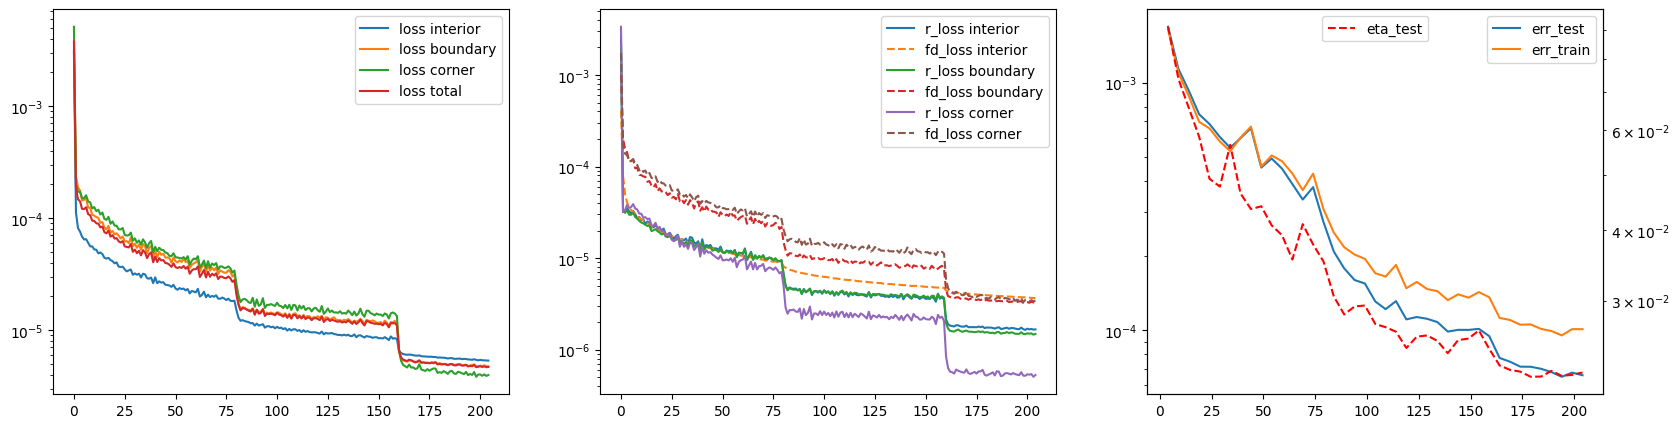

In [11]:
%matplotlib inline
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(history['loss_i'],label='loss interior')
plt.plot(history['loss_b'],label='loss boundary')
plt.plot(history['loss_c'],label='loss corner')
plt.plot(history['loss'],label='loss total')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,2)
plt.plot(history['r_loss_i'],label='r_loss interior')
plt.plot(np.array(history['fd_l_loss_i'])*hyperParams['fd_l_weight'],label='fd_loss interior', linestyle='--')
plt.plot(history['r_loss_b'],label='r_loss boundary')
plt.plot(np.array(history['fd_l_loss_b'])*hyperParams['fd_l_weight'],label='fd_loss boundary', linestyle='--')
plt.plot(history['r_loss_c'],label='r_loss corner')
plt.plot(np.array(history['fd_l_loss_c'])*hyperParams['fd_l_weight'],label='fd_loss corner', linestyle='--')
plt.legend()
plt.gca().set_yscale('log')
plt.subplot(1,3,3)
plt.plot(history['err_epoch'],history['err_test'],label='err_test')
plt.plot(history['err_epoch'],history['err_train'],label='err_train')
plt.legend()
plt.gca().set_yscale('log')
plt.gca().twinx()
plt.plot(history['err_epoch'],history['eta_test'],'--',label='eta_test',color='r')
# plt.plot(history['err_epoch'],history['eta_train'],'--',label='eta_train',color='g')
plt.legend(loc = 'upper center')
plt.gca().set_yscale('log')

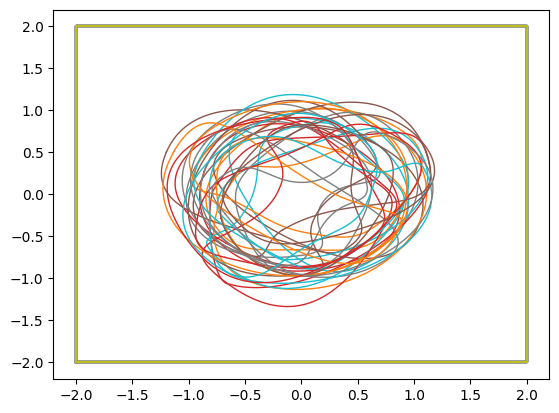

In [229]:
%matplotlib inline
for i in range(30):
    nodesB = data_train[i]['nodesCurves']
    plt.plot(nodesB[0][:,0],nodesB[0][:,1])
    plt.plot(nodesB[1][:,0],nodesB[1][:,1],linewidth=1)
plt.show()

# for i in range(10):
#     nodesB = data_test_remesh[i]['nodesCurves']
#     plt.plot(nodesB[0][:,0],nodesB[0][:,1])
#     plt.plot(nodesB[1][:,0],nodesB[1][:,1])
# plt.show()

In [379]:
modelFolder = r'Models/LowReFlow/model_9_2to3_xBC_1'
Save(modelFolder,encoder,encoderB,decoder,P,history,hyperParams)

In [20]:
modelFolder = r'Models/LowReFlow/model_3_2to3_xBC'
encoder,encoderB,decoder,P,history,hyperParams = LoadModels(modelFolder)
r = hyperParams['n_latent']
nodesIE = np.array(hyperParams['nodesIE'])
distanceBE = np.array(hyperParams['distanceBE'])
nodesD = np.array(hyperParams['nodesD'])

In [24]:
A = GetA(P).numpy()
print(A[0:3,0:3])
print(A[3:6,3:6])
print(A[0:3,3:6]+A[3:6,0:3])

[[ 0.3953247   0.08159652 -0.18121786]
 [ 0.08159652  0.5437784  -0.18259735]
 [-0.18121786 -0.18259735  1.3170145 ]]
[[1.5461925  1.3650535  0.86078215]
 [1.3650535  1.7885795  0.14415698]
 [0.86078215 0.14415698 1.1910071 ]]
[[-0.9584631  -0.28518623  0.84663117]
 [-0.28518623  0.29508862  1.2312014 ]
 [ 0.84663117  1.2312014   0.8654581 ]]


Encoded latent fields


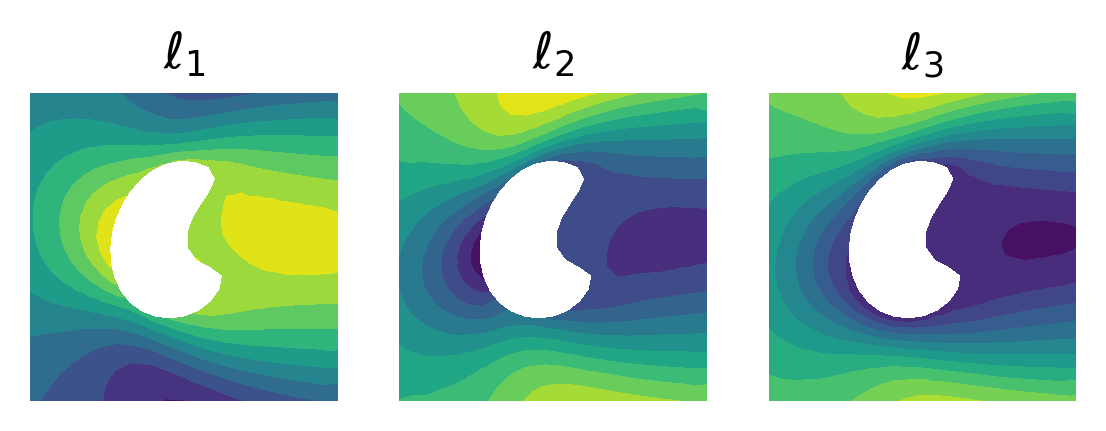

Solved latent fields


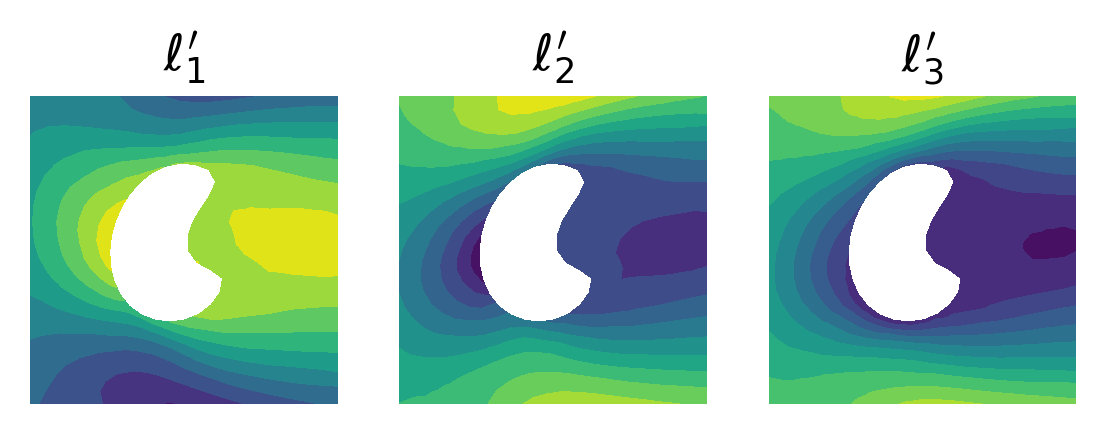

SINN predicted velocity fields


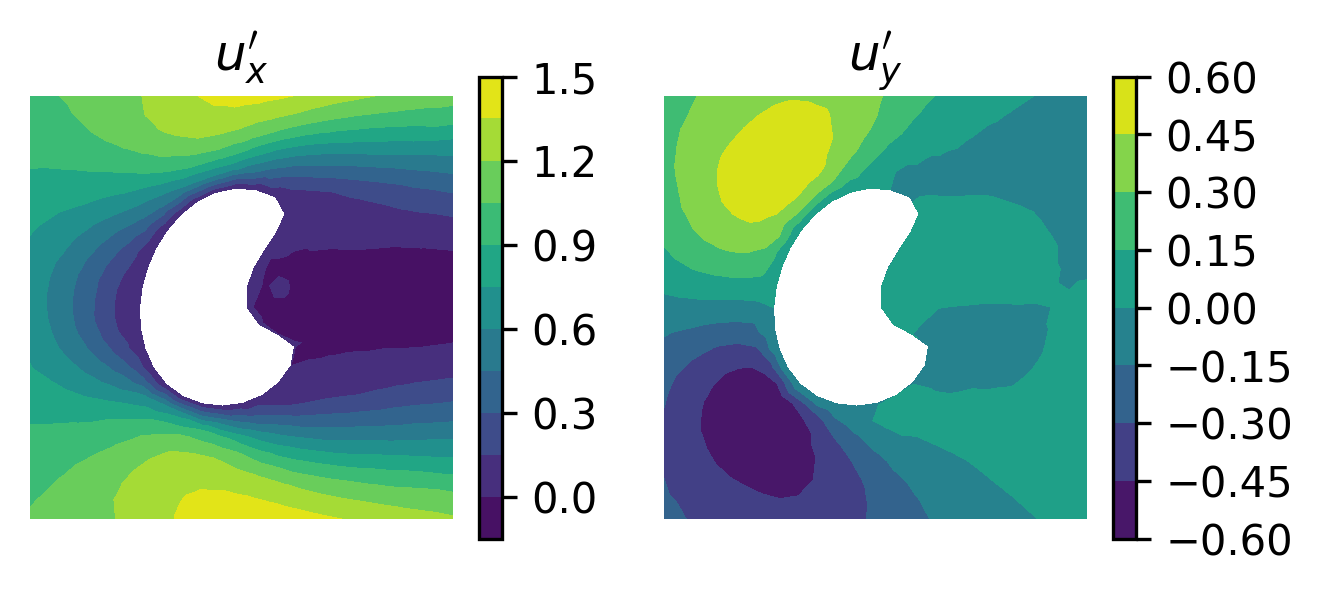

True velocity fields


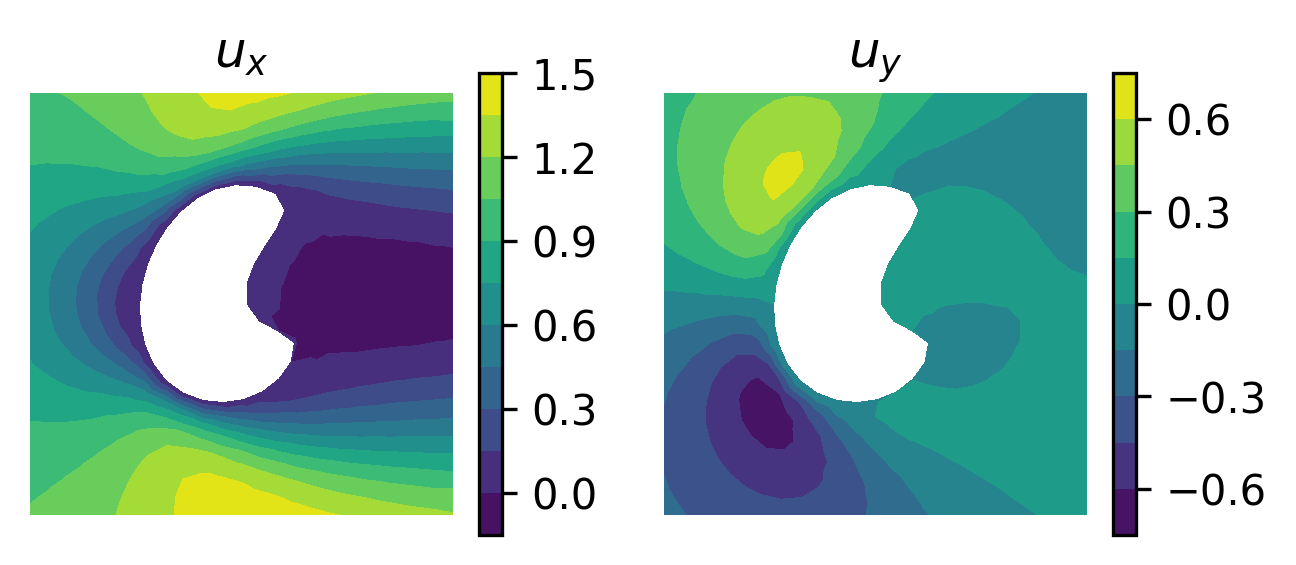

Error velocity fields


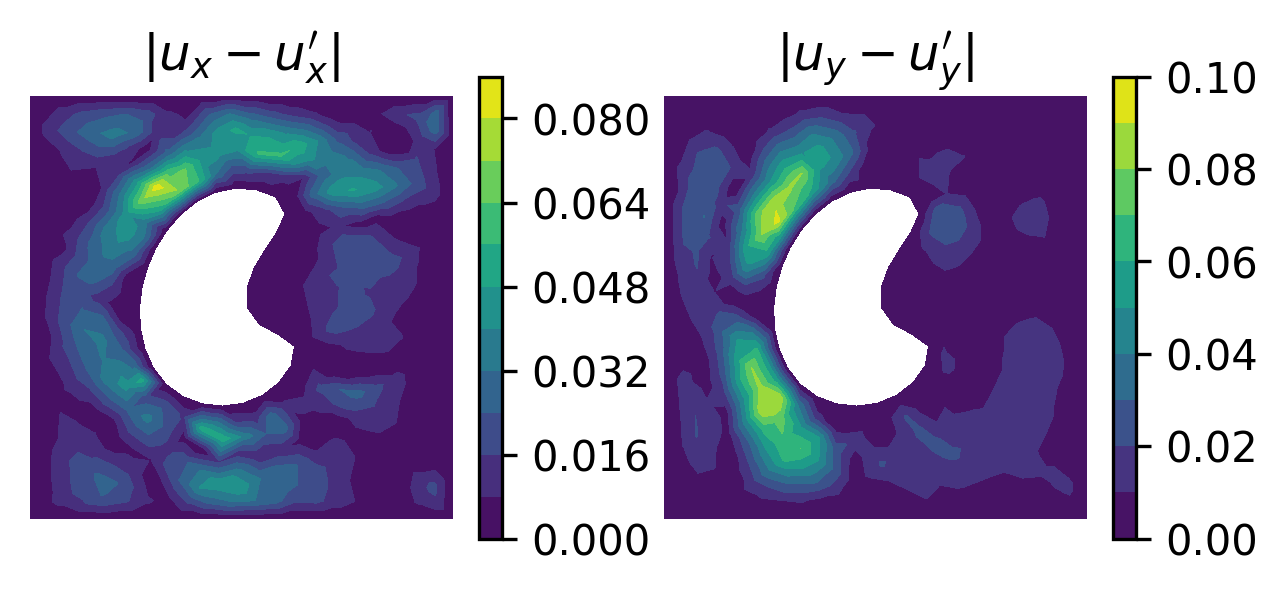

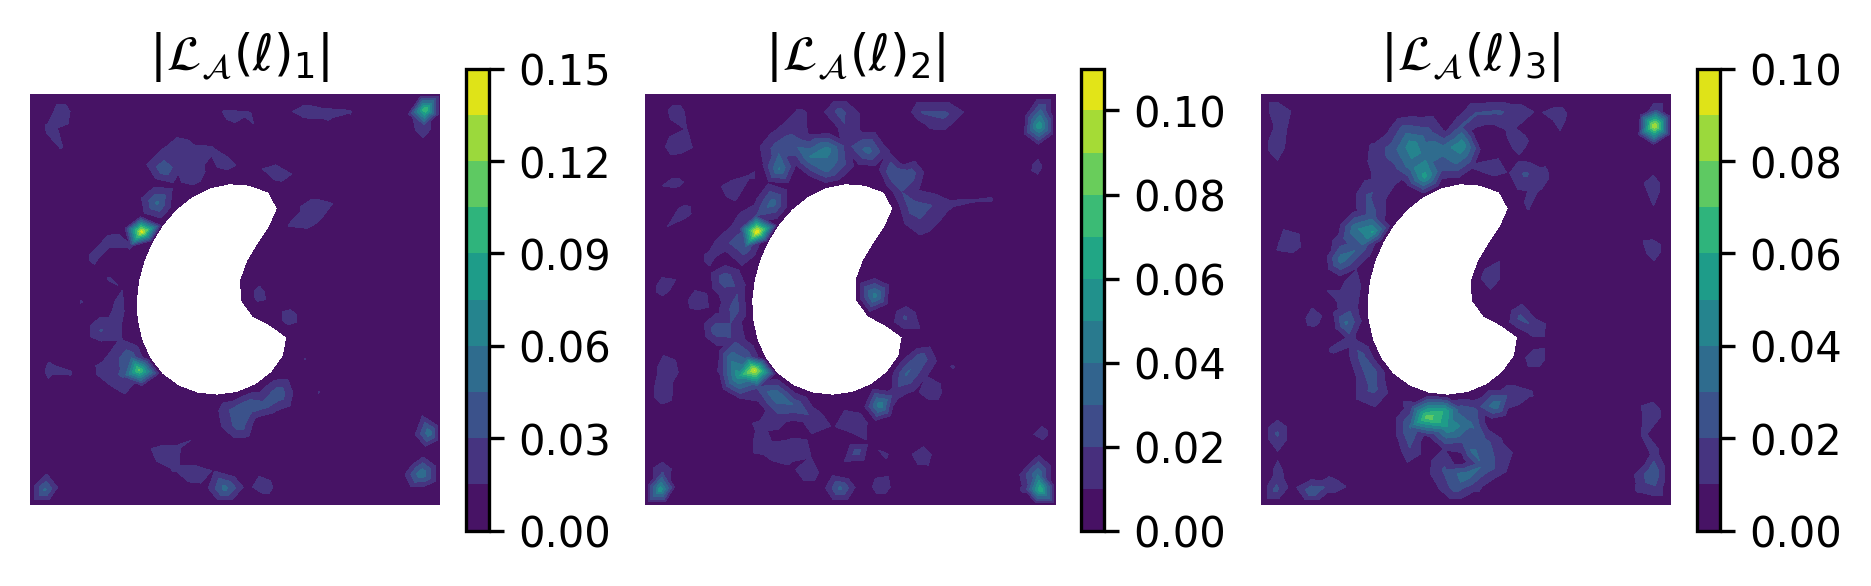

In [21]:
def GenerateGeometry2(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    
    for i in range(4):
        g.line([i,(i+1)%4],marker=1)
    g.spline(list(range(4,p.shape[0]))+[4],marker=2)
    g.surface([0,1,2,3],[[4]])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = [np.array(bdofs[1])-1,np.array(bdofs[2])-1]
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), np.concatenate(boundaryNodes))
    return nodes, elements, boundaryNodes, internalNodes

def computeLengthAlongCurve(nodesB):
    dl = np.sqrt(((nodesB[1:]-nodesB[:-1])**2).sum(1))
    l = np.cumsum(dl)
    l = np.concatenate([[0],l],0)
    return l

def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    for i in range(len(boundaryNodes)):
        plt.plot(nodes[boundaryNodes[i],0],nodes[boundaryNodes[i],1],'r')
    plt.gca().set_aspect('equal', adjustable='box')

def PlotFEMsolution(nodes, elements,l, axisLabels = True, useColorBar = True, labels = False, subplotsize=(6,5),dpi = 100):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    n_rows = np.ceil(r/3).astype(int)
    n_cols = min(r,3)
    plt.figure(figsize=(subplotsize[0]*n_cols,subplotsize[1]*n_rows),dpi=dpi)
    for i in range(r):
        plt.subplot(n_rows,n_cols,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        # plt.scatter(nodes[:,0],nodes[:,1],s=100,c=l[:,i])
        if useColorBar:
            plt.colorbar()
        if axisLabels:
            plt.xlabel('x')
            plt.ylabel('y')
        else:
            plt.axis('off')
        if labels:
            plt.title(labels[i])
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

def residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, A_l):

    # Assemble the global stiffness matrix
    res = np.zeros((nodes.shape[0], r))
    res_flat = res.flatten()
    l_flat = l.flatten()
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        K_el = GetK_el_triang(A_l,nodes_el)
        res_flat[el_idx] += K_el @ l_flat[el_idx]


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    res_flat[bc_idx] = 0
    res = res_flat.reshape(-1,r)
    return res

idx = 1 #1
# data_idx_remeshed = RemeshData(data_train[idx],0.2)
data_idx_remeshed = data_test_remesh[idx]

l = EncodeData(data_idx_remeshed,encoder,encoderB, nodesIE, distanceBE)
nodes = data_idx_remeshed['nodes']
elements = data_idx_remeshed['elements']

print("Encoded latent fields")
PlotFEMsolution(nodes, elements,l,useColorBar=False, axisLabels=False, labels=[f'$\ell_{i+1}$' for i in range(r)],subplotsize=(1.5,1.7),dpi=300)

u_model, l_model = SINNsPredict(data_idx_remeshed,encoderB,decoder,P,r,distanceBE)

print("Solved latent fields")
PlotFEMsolution(nodes, elements,l_model,useColorBar=False, axisLabels=False, labels=[f'$\ell_{i+1}\'$' for i in range(r)],subplotsize=(1.5,1.7),dpi=300)
print("SINN predicted velocity fields")
PlotFEMsolution(nodes, elements,u_model,axisLabels=False,labels=['$u_x\'$','$u_y\'$'],subplotsize=(2.5,2),dpi=300)
print("True velocity fields")
PlotFEMsolution(nodes, elements,data_idx_remeshed['solution'][...,:2],axisLabels=False,labels=['$u_x$','$u_y$'],subplotsize=(2.5,2),dpi=300)
print("Error velocity fields")
PlotFEMsolution(nodes, elements,np.abs(data_idx_remeshed['solution'][...,:2]-u_model),axisLabels=False,labels=['$|u_x-u_x\'|$','$|u_y-u_y\'|$'],subplotsize=(2.5,2),dpi=300)

r = hyperParams['n_latent']
boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data_idx_remeshed['idxCurves']])
internalNodes = data_idx_remeshed['internalNodes']
res = residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, GetA(P).numpy())
PlotFEMsolution(nodes, elements,np.abs(res),axisLabels=False,labels=[' $ |\mathcal{L}_\mathcal{A}(\ell)_{'+str(i+1)+'}|$ ' for i in range(r)],subplotsize=(2.5,2),dpi=300)

# PlotMesh(data_idx_remeshed['nodes'],[d[:-1] for d in data_idx_remeshed['idxCurves']],data_idx_remeshed['elements'])
# PlotMesh(data_train[idx]['nodes'],[d[:-1] for d in data_train[idx]['idxCurves']],data_train[idx]['elements'])

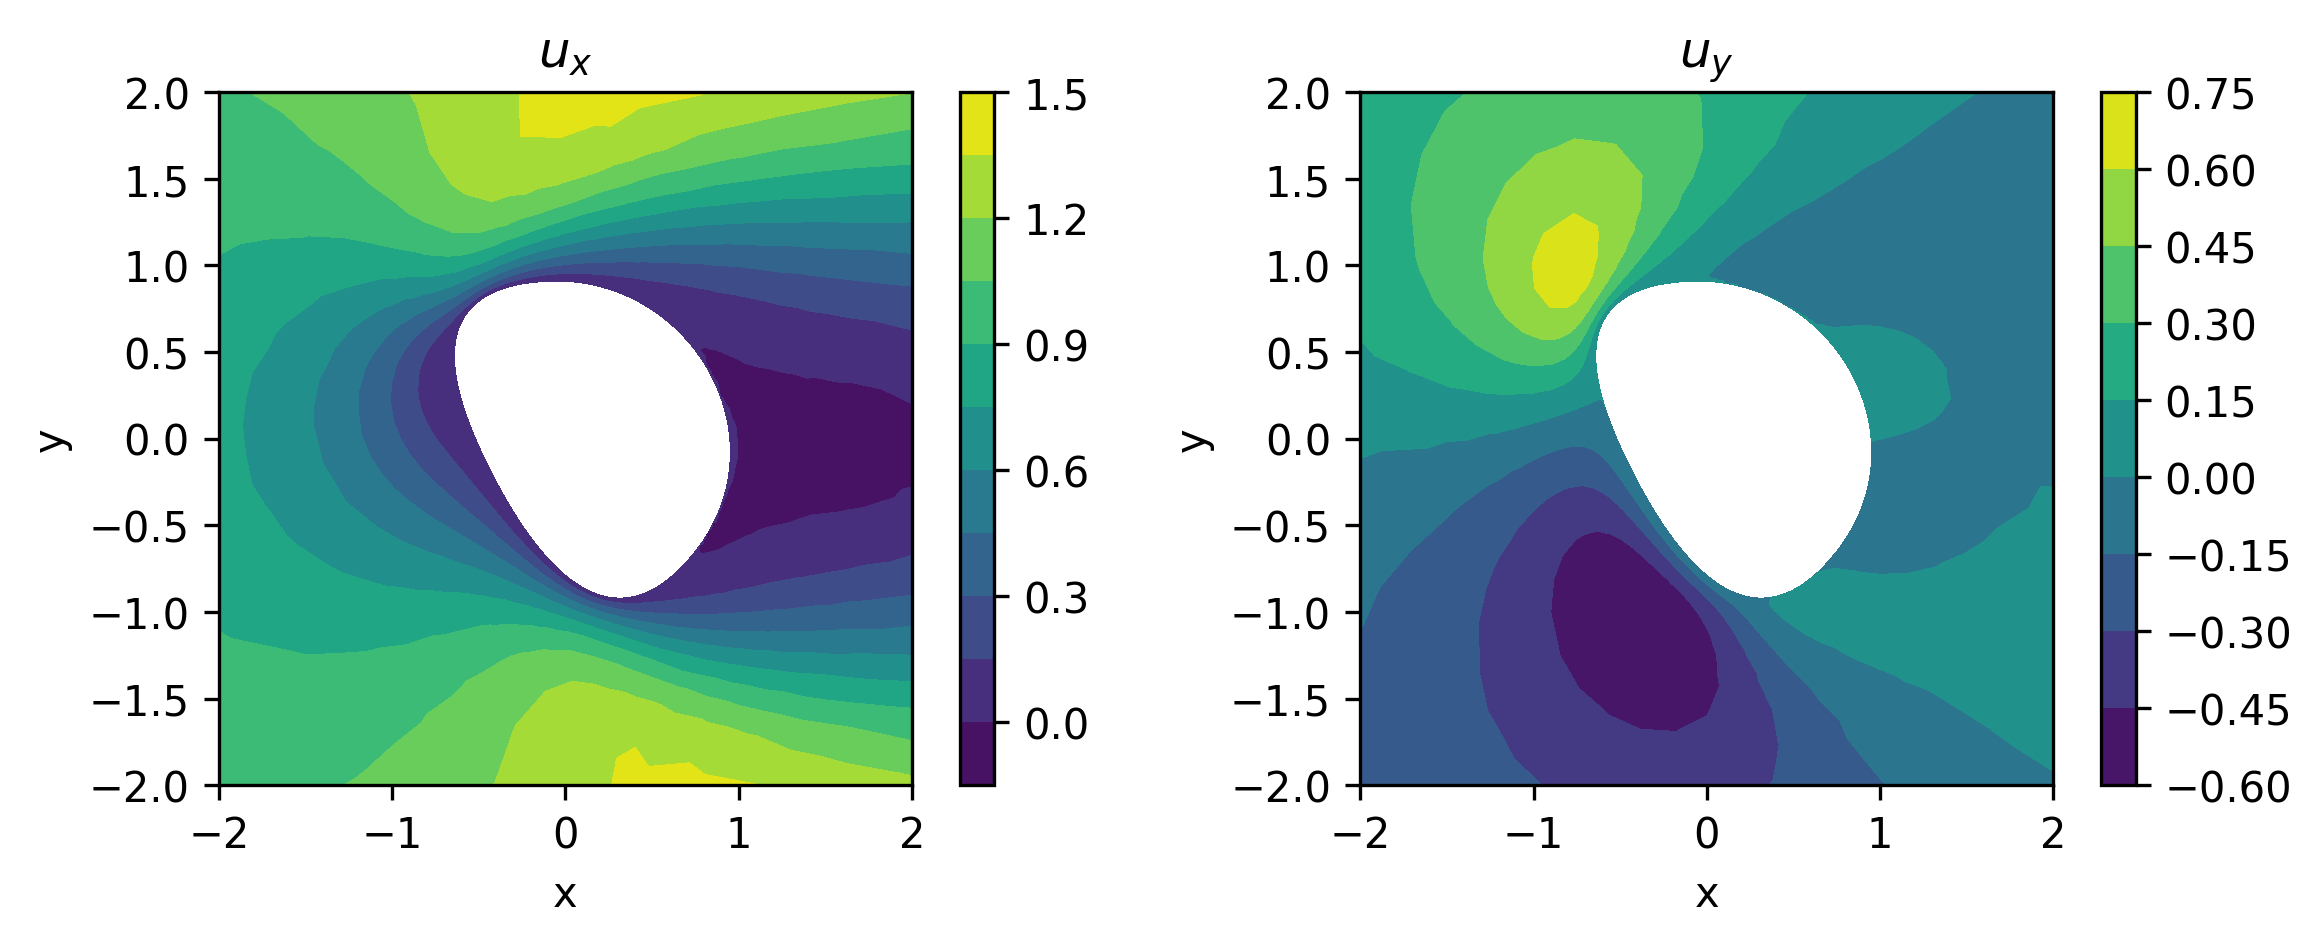

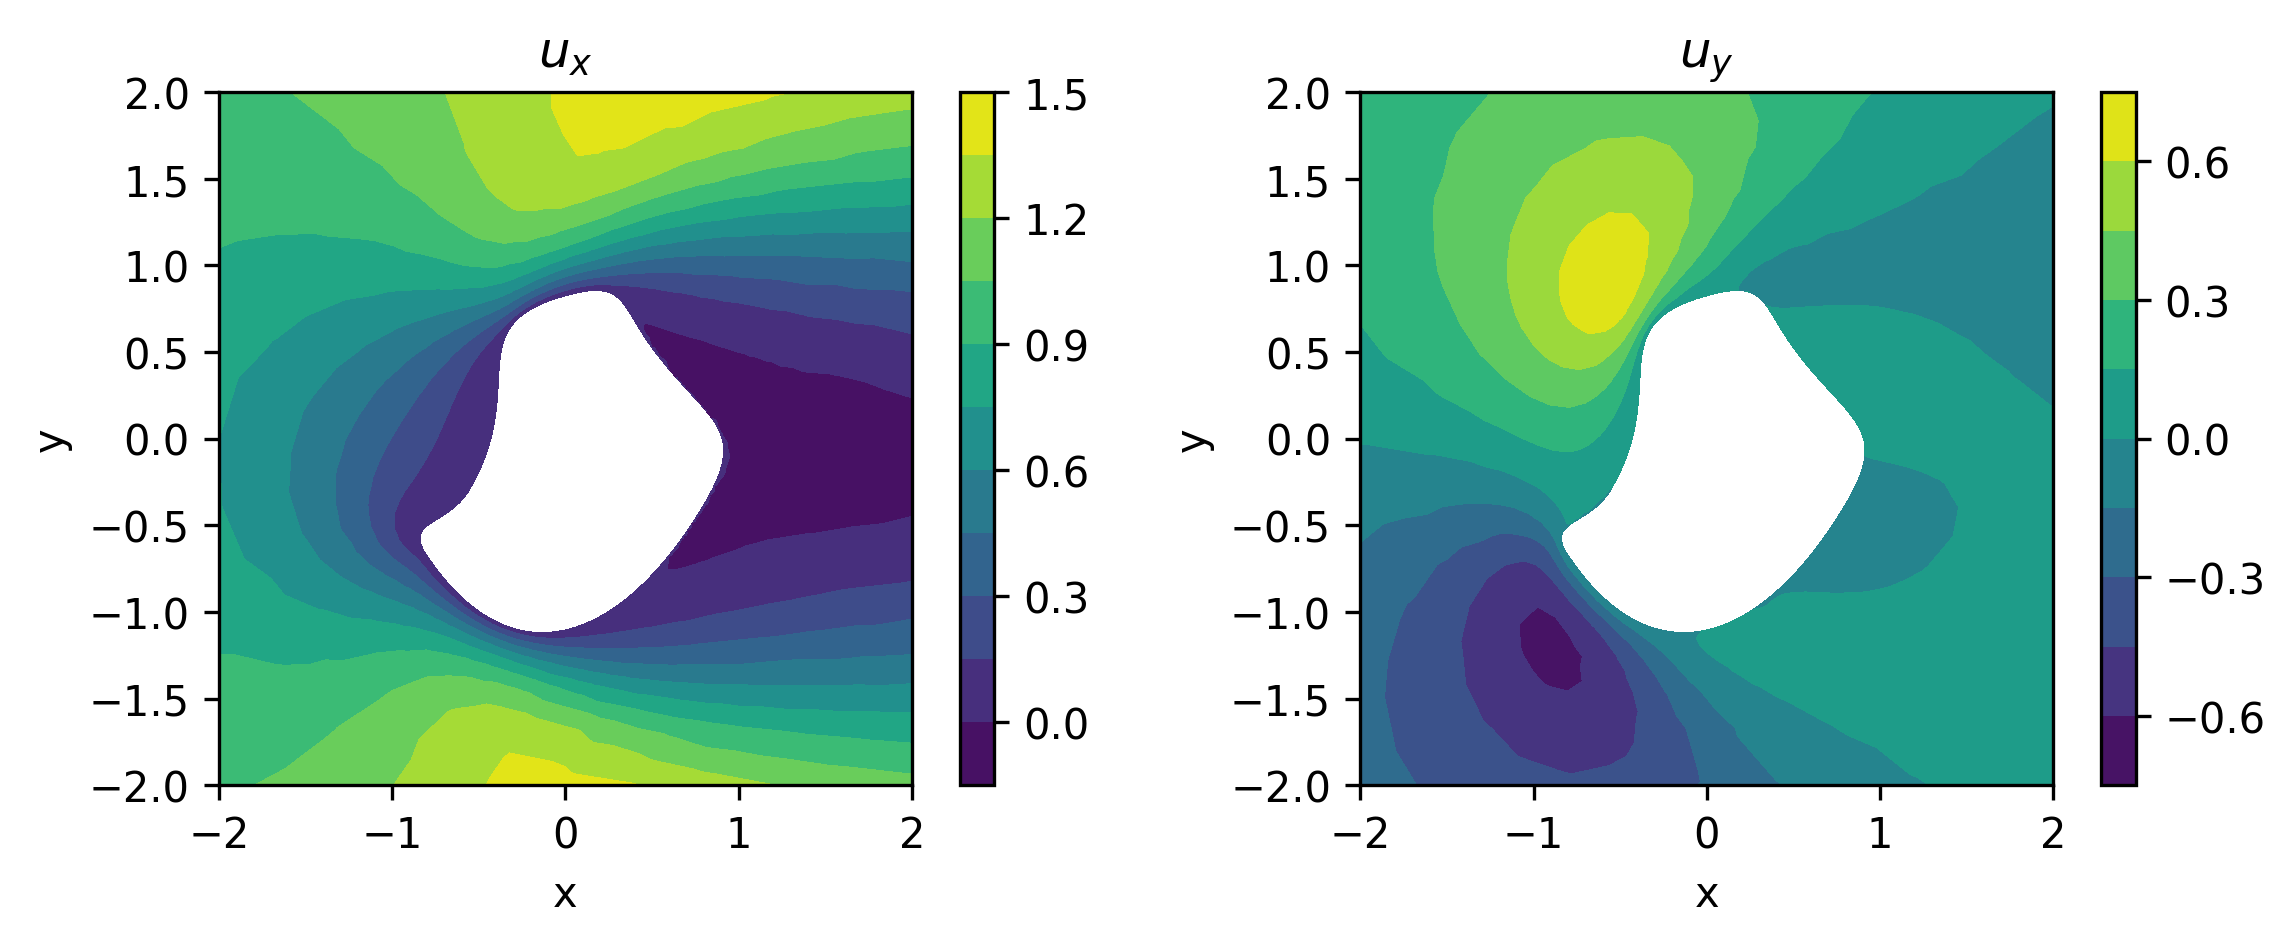

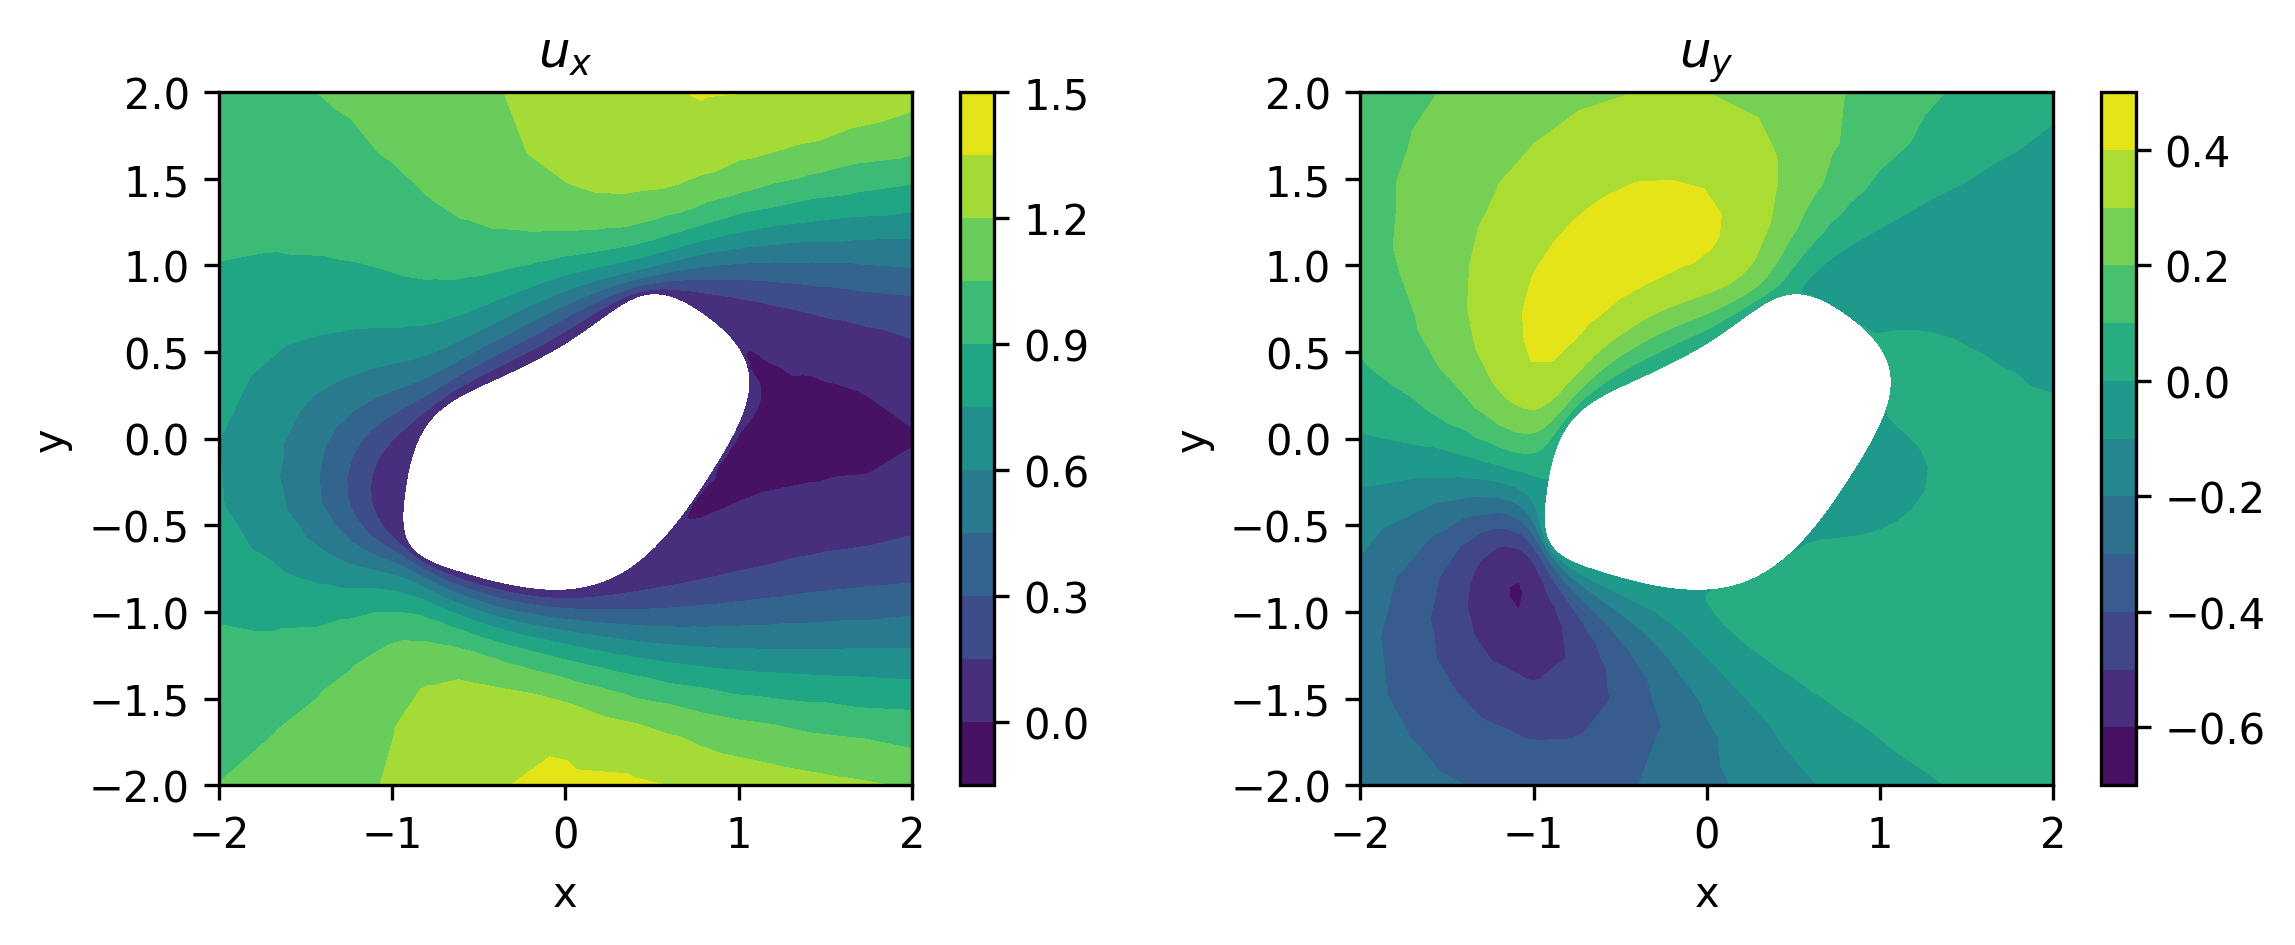

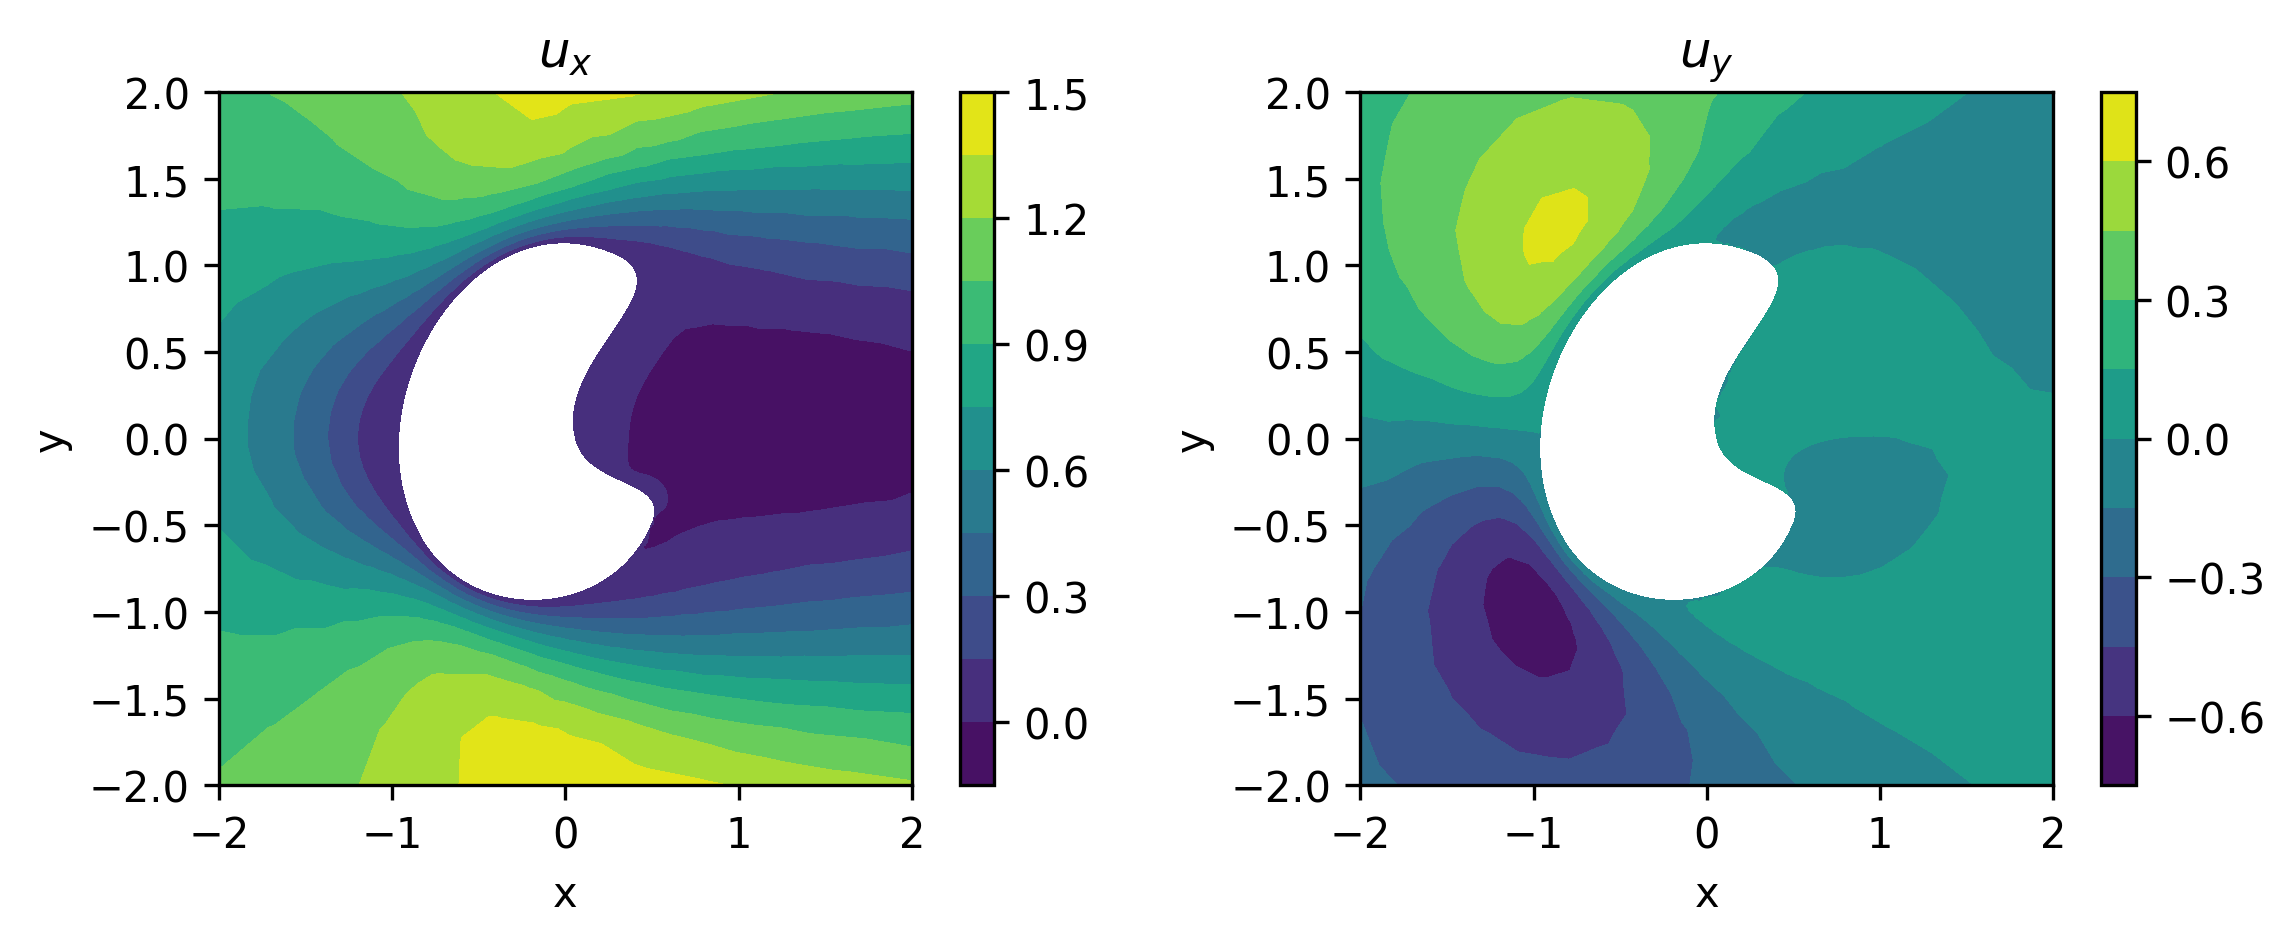

In [302]:
idx_arr = [4,14,21,-9]
for i in range(4):
    data_i = data[idx_arr[i]]
    PlotFEMsolution(data_i['nodes'],data_i['elements'],data_i['solution'][...,:2], axisLabels=True, useColorBar=True,labels=['$u_x$', '$u_y$'], subplotsize=(4.5,3),dpi=300)

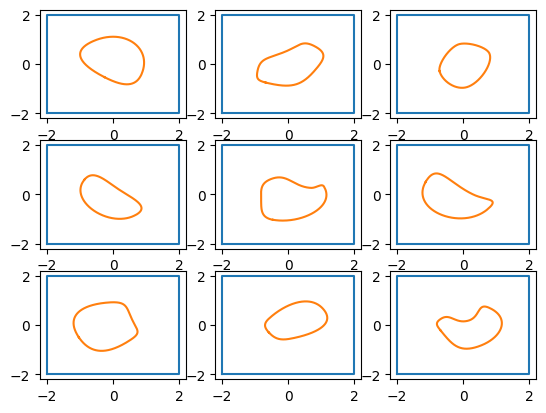

In [289]:
for i in range(9):
    plt.subplot(3,3,i+1)
    data_i = data[i+20]
    nodesCurves = data_i['nodesCurves']
    for nodes in nodesCurves:
        plt.plot(nodes[:,0],nodes[:,1])

In [ ]:
# dataset_test = GetInteriorDatasetFixed(data_train[:1], nodesIE, nodesD, 1000, 1, elSizeMin=1.0, elSizeMax=1.00001,sRand=0.1, variableElSize=True)

dataset_iter = iter(dataset)
nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D = dataset_iter.next()
loss, lossLog = InteriorForwardPass(encoder, decoder, GetA(P), int(P.shape[0]/2), nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D,hyperParams['fd_l_weight'], hyperParams['elliptc_weight'])

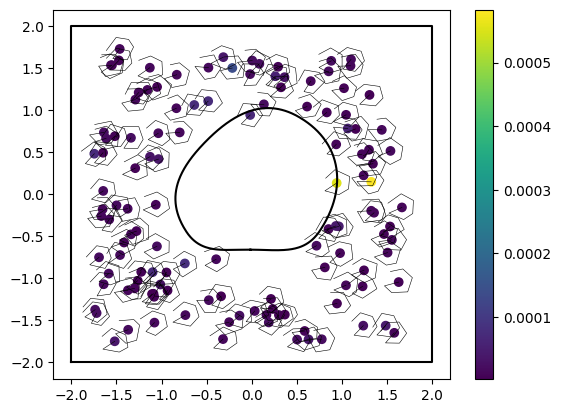

In [ ]:
elSize = np.sqrt(np.square((nodesTP[:,1:,:]-nodesTP[:,0:1,:])).sum(-1)).mean(1)
%matplotlib inline
# %matplotlib qt
plt.scatter(nodesTP[:,0,0],nodesTP[:,0,1],c=loss)
# plt.scatter(nodesTP[:,0,0],nodesTP[:,0,1],c=np.log10(loss))
# plt.scatter(np.reshape(nodesTP[:,:,0],[-1]),np.reshape(nodesTP[:,:,1],[-1]),c=np.reshape(l[:,:,0],[-1]),alpha=1,cmap='jet',s=10)
plt.colorbar()

for i in range(nodesTP.shape[0]):
    plt.plot(nodesTP[i,:,0],nodesTP[i,:,1],'k',linewidth=0.4)

nodesCurves = data_train[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1],'k')

In [ ]:
# dataset_b_test = GetBoundaryDatasetFixed(data_train[:1], nodesIE, distanceBE, nodesD, 1000, 1, elSizeMin=0.1, elSizeMax=0.2, elSizeBF=True)
nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D = dataset_b.as_numpy_iterator().next()
loss, lossLog = BoundaryForwardPass(encoder, encoderB, decoder, GetA(P), int(P.shape[0]/2), nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, hyperParams['fd_l_weight'], hyperParams['elliptc_weight'])

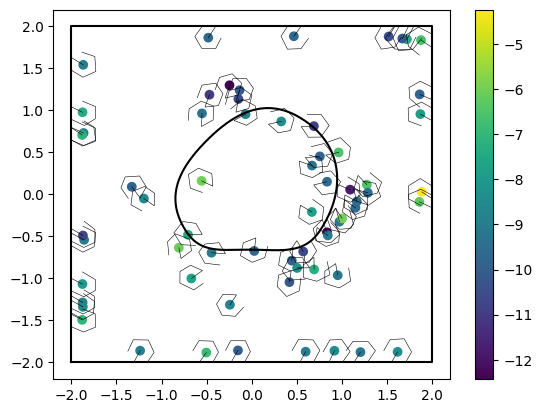

In [ ]:
%matplotlib inline
plt.scatter(nodesTPB[:,0,0],nodesTPB[:,0,1],c=np.log(loss))
# plt.scatter(nodesTPB[:,0,0],nodesTPB[:,0,1],c=(loss))
plt.colorbar()

for i in range(nodesTPB.shape[0]):
    plt.plot(nodesTPB[i,:,0],nodesTPB[i,:,1],'k',linewidth=0.4)

nodesCurves = data_train[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1],'k')

In [ ]:
dc = dataset_c.as_numpy_iterator().next()
nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D = dc

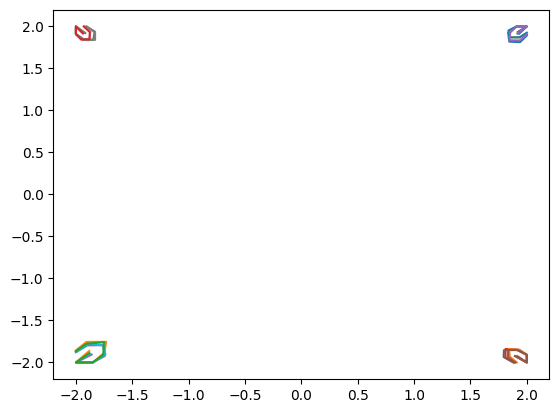

In [ ]:
for i in range(nodesTPC.shape[0]):
    plt.plot(nodesTPC[i,:,0],nodesTPC[i,:,1])

(array([5., 4., 2., 1., 0., 0., 0., 2., 1., 1.]),
 array([0.1001154 , 0.1082296 , 0.1163438 , 0.124458  , 0.13257219,
        0.14068639, 0.1488006 , 0.15691479, 0.16502899, 0.17314318,
        0.18125738]),
 <BarContainer object of 10 artists>)

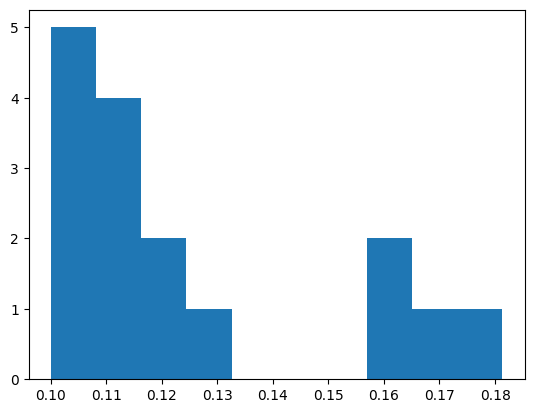

In [ ]:
plt.hist(np.sqrt(((nodesTPC[:,0:1] - nodesTPC[:,1:2])**2).sum(-1)).flatten(),bins=10)

In [96]:
['{:.1g}'.format(i) for i in r_arr]

['2', '3', '6', '9']

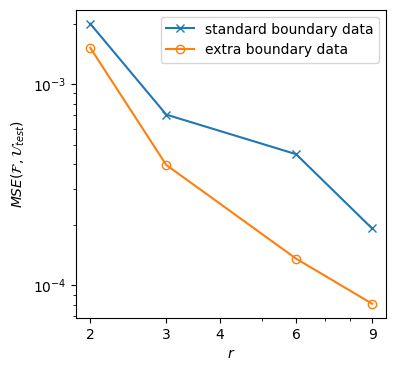

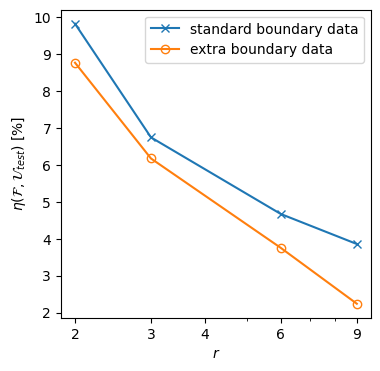

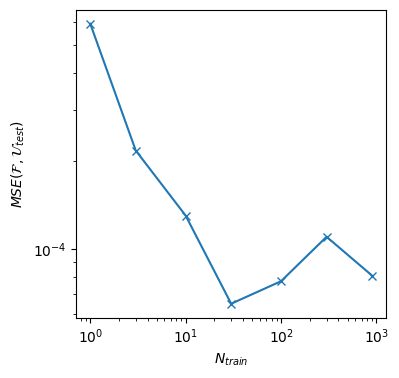

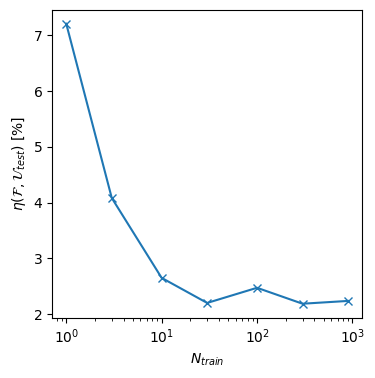

In [385]:
r_arr = [2,3,6,9]
mse_1 = [0.001997,	0.0007057,	0.0004486,	0.0001917]
eta_1 = np.array([0.09831,	0.0675,	0.04672,	0.03859])*100

mse_2 = [0.001516288,	0.0003967,	0.0001357,	8.10E-05]
eta_2 = np.array([0.08774478,	0.06178,	0.03753,	0.0224])*100

dpi=100
plt.figure(figsize=(4,4),dpi=dpi)
plt.plot(r_arr,mse_1,'-x',label='standard boundary data')
plt.plot(r_arr,mse_2,'-o',label='extra boundary data', markerfacecolor='none')
plt.legend()
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
# define x ticks as integers
plt.xticks([2,3,4,6,9], [2,3,4,6,9])

plt.xlabel('$r$')
plt.ylabel('$MSE(\mathcal{F},\mathcal{U}_{test})$')
plt.show()
plt.figure(figsize=(4,4),dpi=dpi)
plt.plot(r_arr,eta_1,'-x',label='standard boundary data')
plt.plot(r_arr,eta_2,'-o',label='extra boundary data', markerfacecolor='none')
plt.legend()
# plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xticks([2,3,4,6,9], [2,3,4,6,9])
plt.xlabel('$r$')
plt.ylabel('$\eta(\mathcal{F},\mathcal{U}_{test}) \; [\%]$')

N_test = [1,3,10,30,100,300,900]
mse_arr = [0.00059,	0.000217042,	0.00013,	6.49e-05,	7.75e-05,	0.00011,	8.10e-05]
eta_arr = np.array([0.072,	0.040825501,	0.026525133, 0.022038748,	0.02475,	0.021899379,	0.0224])*100
plt.figure(figsize=(4,4),dpi=dpi)
plt.plot(N_test,mse_arr,'-x')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel('$N_{train}$')
plt.ylabel('$MSE(\mathcal{F},\mathcal{U}_{test})$')
plt.show()
plt.figure(figsize=(4,4),dpi=dpi)
plt.plot(N_test,eta_arr,'-x')
plt.gca().set_xscale('log')
plt.xlabel('$N_{train}$')
plt.ylabel('$\eta(\mathcal{F},\mathcal{U}_{test}) \; [\%]$')
plt.show()

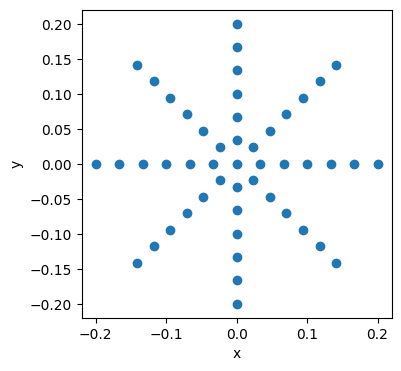

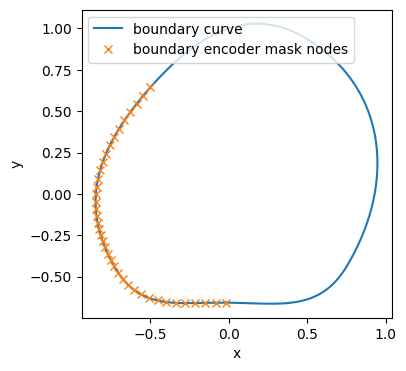

In [180]:
plt.figure(figsize=(4,4),dpi=100)
plt.plot(nodesIE[:,0],nodesIE[:,1],'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
plt.figure(figsize=(4,4),dpi=100)
points = data[0]['interpBC'][1](distanceBE+1)
nodesB = data[0]['nodesCurves'][1]
plt.plot(nodesB[:,0],nodesB[:,1],label='boundary curve')
plt.plot(points[:,0],points[:,1],'x',label='boundary encoder mask nodes')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

Encoded latent fields


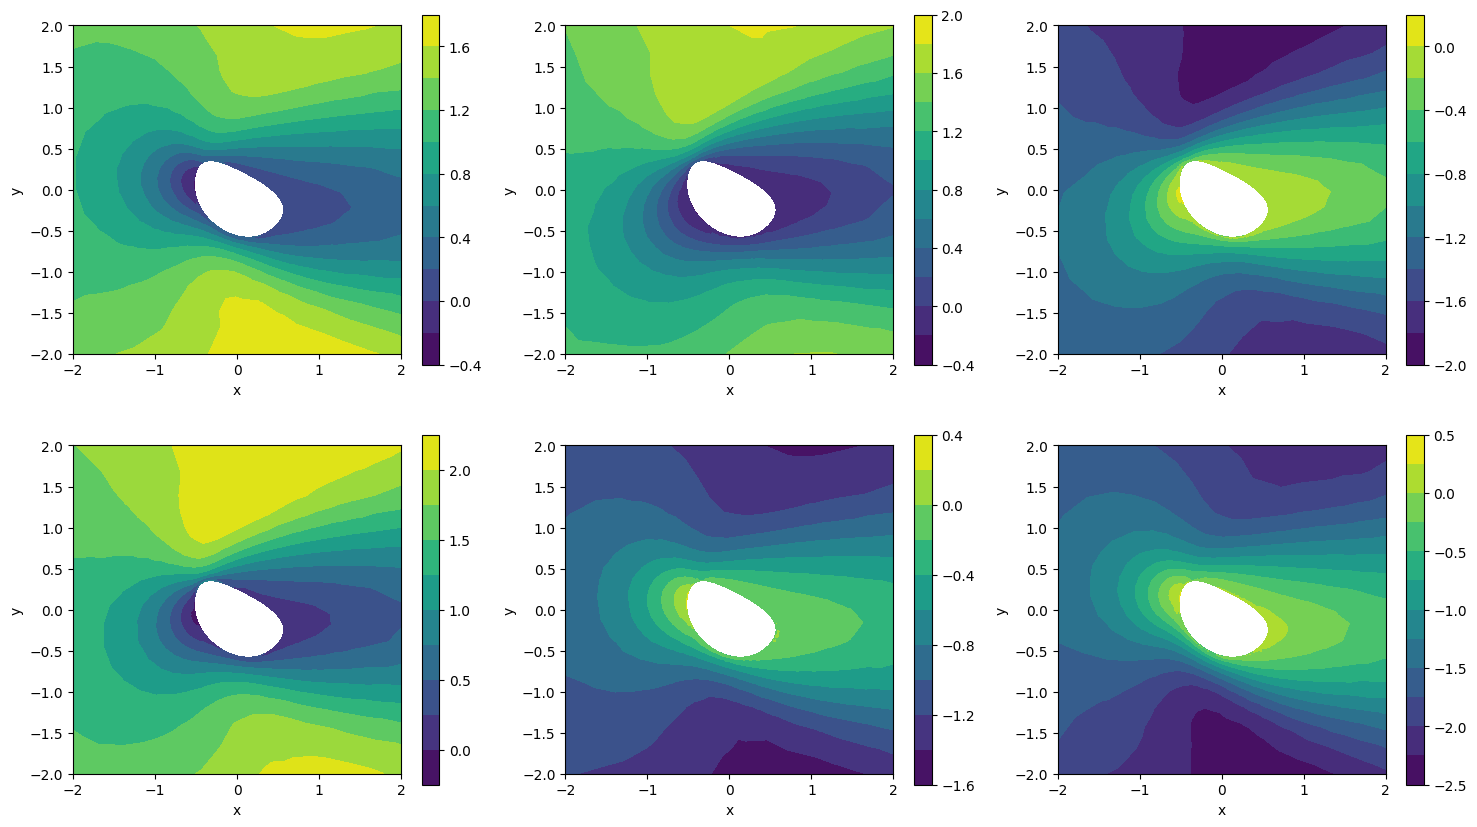

Solved latent fields


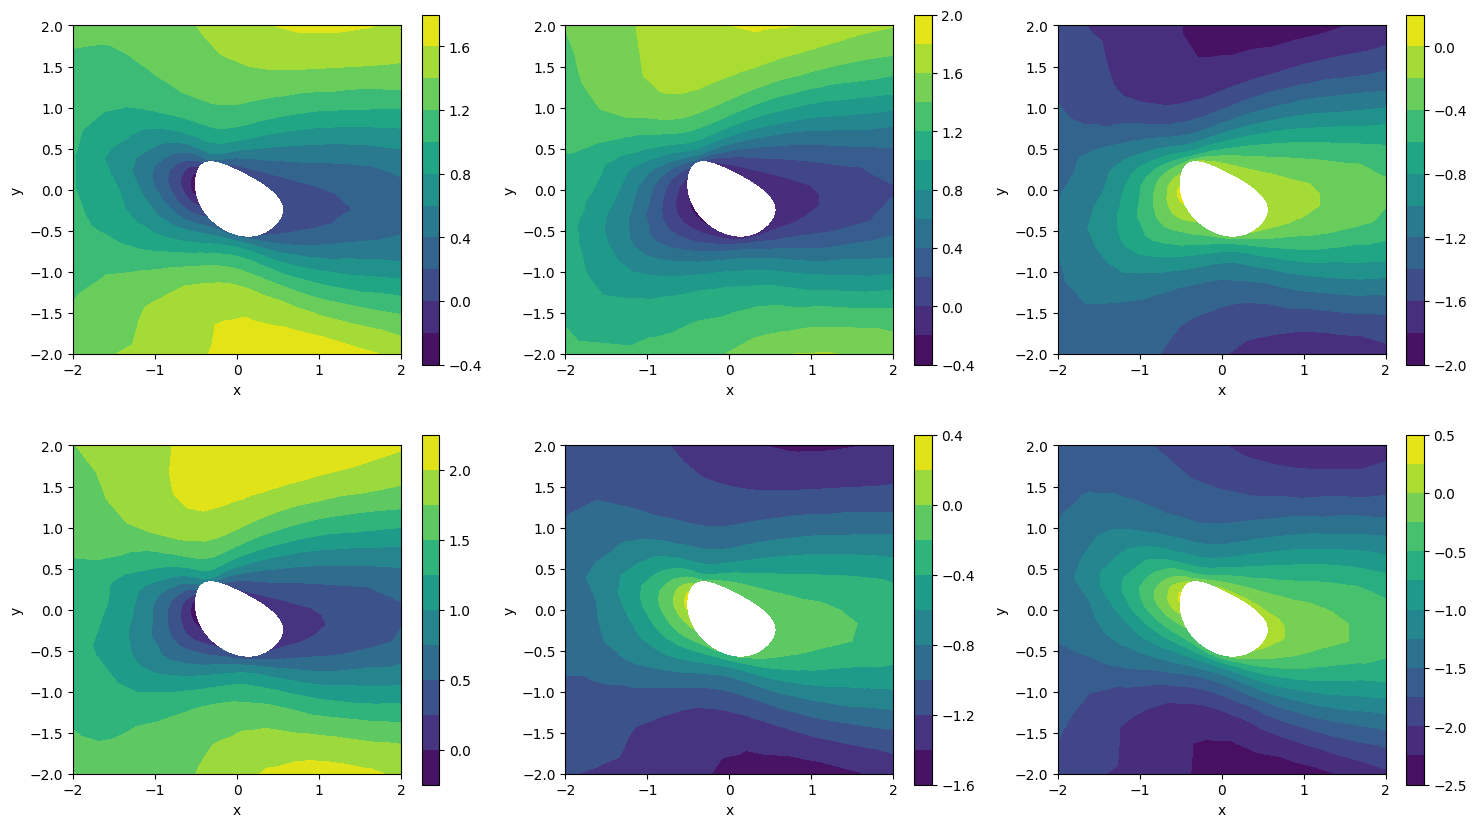

SINN predicted velocity fields


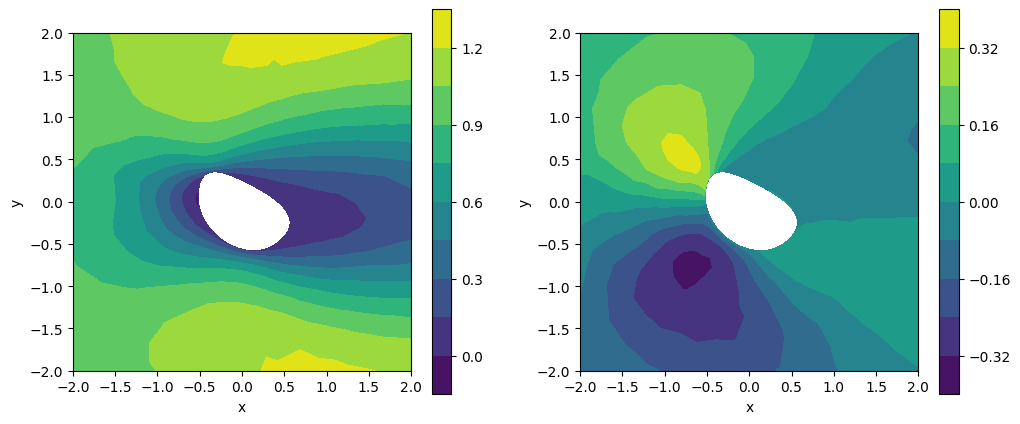

True velocity fields


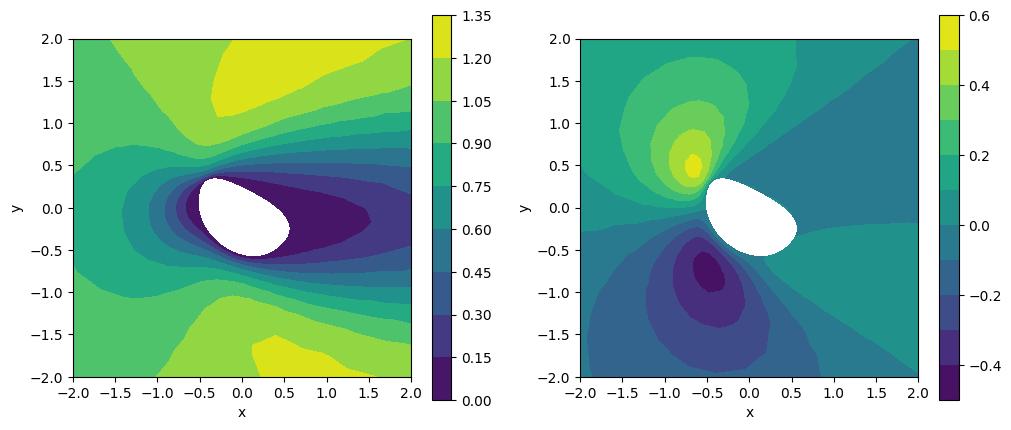

In [ ]:
def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def SolveFEM(nodes, elements, boundaryNodes, l_BC, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SINNsPredict(data,encoderB,decoder,B,r,distanceBE):
    nodes = data['nodes']
    elements = data['elements']
    boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data['idxCurves']])
    internalNodes = np.setdiff1d(np.unique(elements.flatten()),boundaryNodes)
    u_D = data['solution'][...,:2]
    # distance= data['distanceCurves']
    distance = [d[:-1] for d in data['distanceCurves']]
    interpBS = data['interpBS']
    interpBN = data['interpBN']
    nd_BE = data['interpBS'][0].spline.c.shape[-1]

    dBE_S = [(d.reshape(-1,1) + distanceBE.reshape(1,-1)) for d in distance]
    u_BE = [interpBS[i](d.flatten()).reshape(d.shape[0],d.shape[1],nd_BE) for i,d in enumerate(dBE_S)]
    u_BE = np.concatenate(u_BE,0)
    normal_BE = [interpBN[i](d.flatten()).reshape(d.shape[0],d.shape[1],2) for i,d in enumerate(dBE_S)]
    normal_BE = np.concatenate(normal_BE,0)

    lB = encoderB([u_BE,normal_BE])


    l_model = SolveFEM(nodes, elements, boundaryNodes, lB.numpy(), internalNodes, r, GetA(B).numpy())
    l_modelI = l_model[internalNodes]
    u_modelI = decoder(l_modelI)
    u_model = u_D.copy()
    u_model[internalNodes] = u_modelI[:,0,:].numpy()
    return u_model, l_model

def EncodeData(data,encoder,encoderB, nodesIE, distanceBE):
    nodes = data['nodes']
    boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data['idxCurves']])
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]),boundaryNodes)
    nodesI = nodes[internalNodes]
    distance = [d[:-1] for d in data['distanceCurves']]
    interpSE = data['interpSE']
    interpBS = data['interpBS']
    interpBN = data['interpBN']
    isInDomainF = data['isInDomainF']
    # nd_IE = data['interpSE'].nDims
    nd_BE = data['interpBS'][0].spline.c.shape[-1]
    # nd_D = data['interpSD'].nDims

    dBE_S = [(d.reshape(-1,1) + distanceBE.reshape(1,-1)) for d in distance]
    u_BE = [interpBS[i](d.flatten()).reshape(d.shape[0],d.shape[1],nd_BE) for i,d in enumerate(dBE_S)]
    u_BE = np.concatenate(u_BE,0)
    normal_BE = [interpBN[i](d.flatten()).reshape(d.shape[0],d.shape[1],2) for i,d in enumerate(dBE_S)]
    normal_BE = np.concatenate(normal_BE,0)

    lB = encoderB([u_BE,normal_BE])

    nodesI_IE = GetEncoderInputTP(nodesI,nodesIE)
    uI_IE = interpSE(nodesI_IE.reshape(-1,2)).reshape(nodesI_IE.shape[0],nodesI_IE.shape[1],-1)
    bI_IE = isInDomainF(nodesI_IE.reshape(-1,2)).reshape(nodesI_IE.shape[0],nodesI_IE.shape[1],-1)
    uI_IE[~bI_IE[:,:,0]] = 0.0

    lI = encoder([uI_IE,bI_IE])

    l = np.zeros((nodes.shape[0],lI.shape[-1]))
    l[internalNodes] = lI
    l[boundaryNodes] = lB
    return l

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    n_rows = np.ceil(r/3).astype(int)
    n_cols = min(r,3)
    plt.figure(figsize=(6*n_cols,5*n_rows))
    for i in range(r):
        plt.subplot(n_rows,n_cols,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        # plt.scatter(nodes[:,0],nodes[:,1],s=100,c=l[:,i])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

idx = 0
l = EncodeData(data_train[idx],encoder,encoderB, nodesIE, distanceBE)
nodes = data_train[idx]['nodes']
elements = data_train[idx]['elements']

%matplotlib inline
print("Encoded latent fields")
PlotFEMsolution(nodes, elements,l)

u_model, l_model = SINNsPredict(data_train[idx],encoderB,decoder,P,r,distanceBE)

print("Solved latent fields")
PlotFEMsolution(nodes, elements,l_model)
print("SINN predicted velocity fields")
PlotFEMsolution(nodes, elements,u_model)
print("True velocity fields")
PlotFEMsolution(nodes, elements,data_train[idx]['solution'][...,:2])

# ms = 20
# plt.scatter(nodes[:,0],nodes[:,1],c=l[:,0],s=ms)
# plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
data_i = data_train[idx]

nodes = data_i['nodes']
elements = data_i['elements']
boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data_i['idxCurves']])
internalNodes = np.setdiff1d(np.unique(elements.flatten()),boundaryNodes)

def residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, A_l):

    # Assemble the global stiffness matrix
    res = np.zeros((nodes.shape[0], r))
    res_flat = res.flatten()
    l_flat = l.flatten()
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        K_el = GetK_el_triang(A_l,nodes_el)
        res_flat[el_idx] += K_el @ l_flat[el_idx]


    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    res_flat[bc_idx] = 0
    res = res_flat.reshape(-1,r)
    return res

r = hyperParams['n_latent']
boundaryNodes = np.concatenate([idxCurve[:-1] for idxCurve in data_i['idxCurves']])
internalNodes = np.setdiff1d(np.unique(elements.flatten()),boundaryNodes)
res = residualFEM(nodes, elements, boundaryNodes, l, internalNodes, r, GetA(P).numpy())
# %matplotlib qt
%matplotlib inline
PlotFEMsolution(nodes, elements,np.abs(res))
# PlotFEMsolution(nodes, elements,np.sqrt(np.abs(res)))

IndexError: index 6090 is out of bounds for axis 0 with size 3180

In [ ]:
A = np.zeros((20,20))
x = np.zeros(20)
internal_idx = np.array([0,1,2,3,4,5,6,7,8,9])
bc_idx = np.array([15,16,17,18,19])
# idx = np.concatenate([internal_idx,bc_idx])
# not_idx = np.setdiff1d(np.arange(20),idx)
A[*np.meshgrid(internal_idx,internal_idx)] = np.random.rand(10,10)
A[*np.meshgrid(bc_idx,internal_idx)] = np.random.rand(10,5)
A[*np.meshgrid(internal_idx,bc_idx)] = np.random.rand(5,10)
A[*np.meshgrid(bc_idx,bc_idx)] = np.random.rand(5,5)

x[internal_idx] = np.random.rand(10)
x[bc_idx] = np.random.rand(5)

res0 = A @ x
res0[bc_idx] = 0
res1_internal = A[internal_idx,:][:,internal_idx] @ x[internal_idx] + A[internal_idx,:][:,bc_idx] @ x[bc_idx]
res1 = np.zeros(20)
res1[internal_idx] = res1_internal

In [ ]:
print(K[2125*r:2125*r+r,2125*r:2125*r+r])
f[2125*r:2125*r+r]

[[ 6.74571938 -2.90510249  0.89307531 -2.72937098 -0.4278578   0.93405809]
 [-2.90510249  6.59072973  0.83232841  0.04381294 -0.96143926  0.41301509]
 [ 0.89307531  0.83232841  3.73181946 -0.72669356  1.26584233 -1.67508065]
 [-2.72937098  0.04381294 -0.72669356  8.67463089 -2.19867409 -0.55576087]
 [-0.4278578  -0.96143926  1.26584233 -2.19867409  3.86259885  0.28027905]
 [ 0.93405809  0.41301509 -1.67508065 -0.55576087  0.28027905  3.41207639]]


array([[-0.21598201],
       [ 0.07997936],
       [-0.02970015],
       [ 0.22358773],
       [-0.016845  ],
       [-0.11023298]])

In [ ]:
df

,l0,l1,l2,l3,l4,l5,x,y
2125,0.053604,0.078162,-0.111672,0.058414,0.101157,-0.127366,-1.60179,-1.69777
0,0.052596,0.077758,-0.113118,0.060371,0.096822,-0.120389,-2.00000,-2.00000
80,0.055360,0.080729,-0.117605,0.060437,0.103777,-0.129841,-1.60000,-2.00000
81,0.057733,0.083199,-0.120757,0.062702,0.108253,-0.135811,-1.20000,-2.00000
1389,0.054086,0.078276,-0.110147,0.059174,0.103584,-0.131568,-1.31300,-1.55126
550,0.050936,0.074835,-0.105069,0.055907,0.097158,-0.123472,-1.65857,-1.37555
115,0.050579,0.074607,-0.110801,0.054990,0.094599,-0.121931,-2.00000,-1.60000


In [ ]:
print(K[1389*r:1389*r+r,1389*r:1389*r+r])
f[1389*r:1389*r+r]

[[ 7.71534203 -2.80809009  1.46137362 -3.99904742 -0.24362476  1.05270988]
 [-2.80809009  5.6339299   0.44429156 -0.10442099 -0.89151537  0.08630428]
 [ 1.46137362  0.44429156  2.93296256 -1.39344976  0.89986924 -0.93761238]
 [-3.99904742 -0.10442099 -1.39344976  9.94398093 -2.5491741  -0.93438991]
 [-0.24362476 -0.89151537  0.89986924 -2.5491741   3.32612014  0.33959627]
 [ 1.05270988  0.08630428 -0.93761238 -0.93438991  0.33959627  2.38545754]]


array([[ 0.04515536],
       [-0.00566105],
       [ 0.05001916],
       [-0.04949836],
       [ 0.01537041],
       [-0.00768222]])

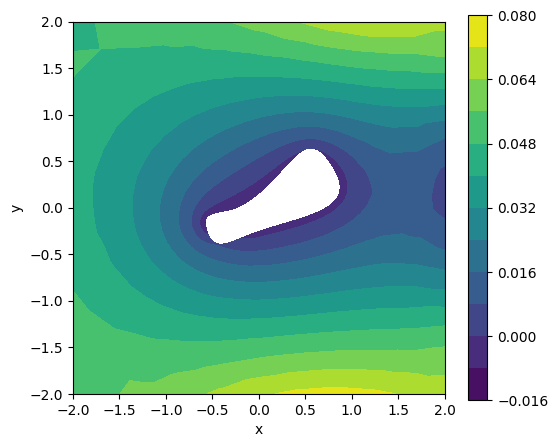

In [ ]:
l_lin = SolveFEM(nodes, elements, boundaryNodes, l[boundaryNodes,0:1], internalNodes, 1, np.eye(2*1))

PlotFEMsolution(nodes, elements,l_lin)

In [ ]:
data_i = data[100]
nodes = data_i['nodes']
elements = data_i['elementsBoundaryNodesOnly']
areaElements = data_i['areaElementsBoundaryNodesOnly']
isInDomainF = data_i['isInDomainF']

n_TP = 300
nodesTP_arr = np.zeros((n_TP,7,2))
elementsTP_arr = np.zeros((n_TP,6,3))
for i in range(n_TP):
    nodesTP_arr[i], elementsTP_arr[i] = GetRandomTPmesh(nodes,elements,areaElements,isInDomainF,elSizeMin=0.1,elSizeMax=0.2)

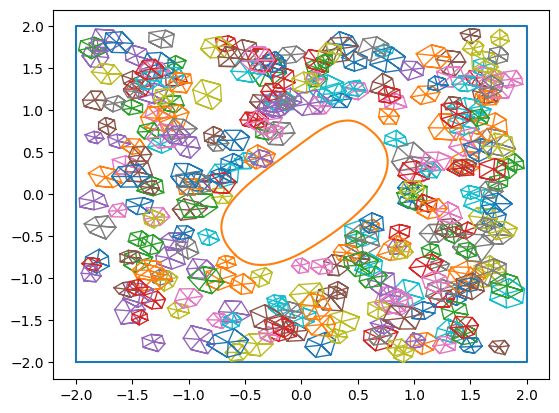

In [ ]:
nodesCurves = data_i['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

idx_mesh = [6,1,2,3,4,5,6,0,1,2,0,3,0,4,5,0]
for i in range(n_TP):
    plt.plot(nodesTP_arr[i,idx_mesh,0],nodesTP_arr[i,idx_mesh,1],linewidth=1)

In [ ]:
el

1502

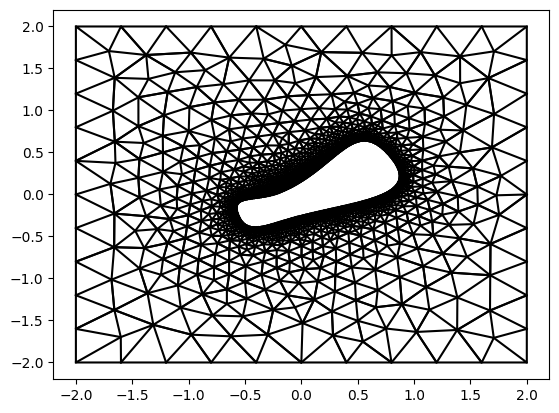

In [ ]:
# plot mesh
plt.figure()
for el in elements2:
    plt.plot(nodes[el,0],nodes[el,1],'k')

In [ ]:
print(np.where(elements==i_node1))
print(np.where(elements==i_node2))

# 629,147

(array([128, 147, 629, 848]), array([0, 0, 1, 0]))
(array([ 147,  434,  629,  670, 1628, 3167]), array([2, 2, 2, 2, 2, 2]))


In [ ]:
print(i_node1,i_node2)
print(elements[[629,147]])

81 2125
[[  80   81 2125]
 [  81 1389 2125]]


In [ ]:
elements2 = elements.copy()
elements2[629] = [80,1389,2125]
elements2[147] = [80,81,1389]

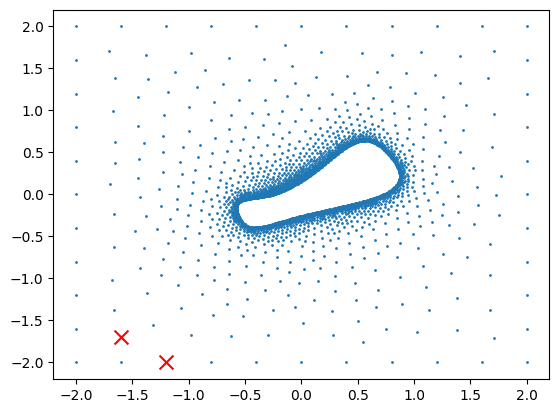

In [ ]:
df_nodes = pd.DataFrame(nodes,columns=['x','y'])
i_node1 = df_nodes[(df_nodes['x']> -1.5) & (df_nodes['x']< -1.0) & (df_nodes['y']<-1.9)].index[0]
i_node2 = df_nodes[(df_nodes['x']> -1.8) & (df_nodes['x']< -1.5) & (df_nodes['y']<-1.6) & (df_nodes['y']>-1.9)].index[0]
plt.scatter(nodes[:,0],nodes[:,1],s=1)
plt.scatter([nodes[i_node1,0]],[nodes[i_node1,1]],c='r',s=100, marker='x')
plt.scatter([nodes[i_node2,0]],[nodes[i_node2,1]],c='r',s=100, marker='x')


In [ ]:
data_i = data[100:101]
nodesIE = GetRadialEncoderInputMask(5,8,0.7,0.3)
nodesD = GetRadialEncoderInputMask(0,0)
elSizeMin = 0.2
elSizeMax = 0.21
debugging = True

while True:
    nodesTP, elementsTP, uTP_IE, bTP_IE, u_D, b_D, nodesTP_IE = GetRandomTrainingPatchInternal(data_i, nodesIE, nodesD, elSizeMin, elSizeMax, debugging)
    if np.any(~bTP_IE):
        break

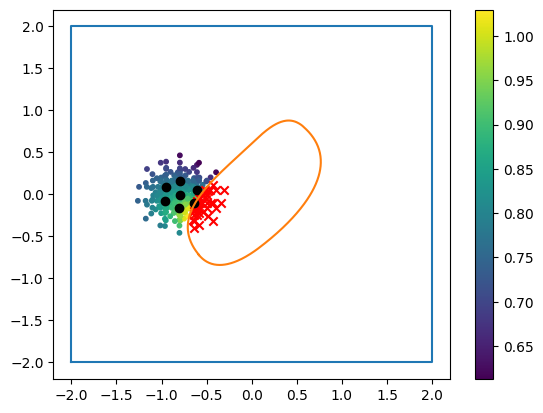

In [ ]:
nodesCurves = data_i[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

nodes_in = nodesTP_IE[bTP_IE[...,0]]
nodes_out = nodesTP_IE[~bTP_IE[...,0]]
u_in = uTP_IE[bTP_IE[...,0]]
u_out = uTP_IE[~bTP_IE[...,0]]
plt.scatter(nodes_in[:,0],nodes_in[:,1],c=u_in[:,2],s=10)
plt.colorbar()
plt.scatter(nodes_out[:,0],nodes_out[:,1],c='r', marker='x')
plt.scatter(nodesTP[:,0],nodesTP[:,1],c='k', marker='o')
# plt.xlim([-1,0])
# plt.ylim([-0.5,0.5])

In [ ]:
def GetRandomTPmeshBoundary(nodesB,length,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,idx_curve_0=None,distance_0=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

    length = np.array(length)
    if idx_curve_0 is None:
        idx_curve_0 = np.random.choice(np.arange(len(nodesB)),p=length/length.sum())
        # idx_curve_0 = np.random.randint(0,len(nodesB))
    if distance_0 is None:
        distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

    iterations = 0

    while iterations < 1_000:

        elSize = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh

        scale = 1 # scaling factor elSize which is used to fite the training patch mesh in areas of high boundary curvature were distance is not a good measure of the element size
        for i in range(100):
            # iterate to find the second point of the training patch mesh on the boundary
            distance_1 = (distance_0 + elSize*scale)#%length[idx_curve_0] # define the second point of the training patch mesh on the boundary

            # interpolate the boundary nodes between the two sampled points
            nodes_0 = interpNodesB[idx_curve_0](distance_0)
            nodes_1 = interpNodesB[idx_curve_0](distance_1)

            # Computes the appropriate scaling and rotation for the normalized training patch mesh
            rotTPB = -np.arctan2(nodes_1[1]-nodes_0[1],nodes_1[0]-nodes_0[0])
            elSizeTPB = np.sqrt(((nodes_1 - nodes_0)**2).sum())
            if abs(elSizeTPB-elSize)/elSize < 0.1:
                break
            
            scale = scale*np.sqrt(elSize/elSizeTPB)

        rot_mat = np.array([[np.cos(rotTPB),np.sin(rotTPB)],[-np.sin(rotTPB),np.cos(rotTPB)]])
        nodesTPB, elementsTPB = GenerateTriangTrainMeshBoundary()
        nodesTPB = (rot_mat@nodesTPB.T).T * elSizeTPB + nodes_0
        isInDomain = IsInDomainF(nodesTPB[[0,3,4,5,6]])
        
        # Check if the training patch mesh is within the domain and the element size is within the bounds
        if np.all(isInDomain) and (elSizeTPB < elSizeMax) and (elSizeTPB > elSizeMin):
            break
        iterations += 1
        distance_0 = np.random.uniform(0,length[idx_curve_0])# randomly sample a point on the boundary

    # print(iterations)
    return nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0

data_i = data[250]
nodesB = data_i['nodesCurves']
distance = data_i['distanceCurves']
length = data_i['lengthCurves']
interpNodesB = data_i['interpBC']
isInDomainF = data_i['isInDomainF']
elSizeMin=0.1
elSizeMax=0.11
idx_curve_0=None
distance_0=None

n_TPB = 200
nodesTPB_arr = np.zeros((n_TPB,7,2))
elementsTPB_arr = np.zeros((n_TPB,6,3))
for i in range(n_TPB):
    nodesTPB_arr[i], elementsTPB_arr[i],_,_,_ = GetRandomTPmeshBoundary(nodesB,length,interpNodesB,isInDomainF,elSizeMin=0.1,elSizeMax=0.2)

iter: 1; i: 0
iter: 1; i: 0
iter: 1; i: 0
iter: 1; i: 0
iter: 1; i: 0
iter: 1; i: 1
iter: 1; i: 2
iter: 1; i: 0
iter: 1; i: 0
iter: 1; i: 2
iter: 0; i: 9
iter: 1; i: 0
iter: 1; i: 3
iter: 2; i: 0


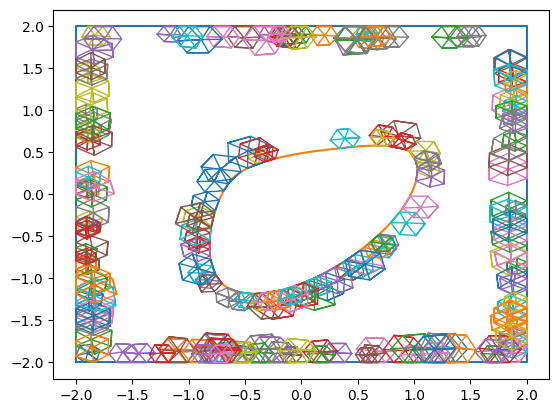

In [ ]:
nodesCurves = data_i['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

idx_mesh = [6,1,2,3,4,5,6,0,1,2,0,3,0,4,5,0]
# plt.plot(nodesTPB[idx_mesh,0],nodesTPB[idx_mesh,1],linewidth=1)
for i in range(n_TPB):
    plt.plot(nodesTPB_arr[i,idx_mesh,0],nodesTPB_arr[i,idx_mesh,1],linewidth=1)

# plt.xlim(1.5,2.1)
# plt.ylim(1.5,2.1)

In [ ]:
def GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))
    nodesB = data[idx]['nodesCurves']
    lengthCurves = data[idx]['lengthCurves']
    interpNodesB = data[idx]['interpBC']
    isInDomainF = data[idx]['isInDomainF']

    # Get random training patch mesh
    nodesTPB, elementsTPB, distance_0, distance_1, idx_curve_0 = GetRandomTPmeshBoundary(nodesB,lengthCurves,interpNodesB,isInDomainF,elSizeMin,elSizeMax)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve_0]
    interpBN = data[idx]['interpBN'][idx_curve_0]

    nodesTP_BEi = GetEncoderInputTP(nodesTPB[[0,3,4,5,6]],nodesIE) # get nodes for the interour encoder input
    uTP_BEi = interpSE(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1],-1)
    bTP_BEi = isInDomainF(nodesTP_BEi.reshape(-1,2)).reshape(nodesTP_BEi.shape[0],nodesTP_BEi.shape[1])
    uTP_BEi[~bTP_BEi] = 0
    distanceTP_BEb = np.array([[distance_0],[distance_1]])+distanceBE # get alpha for the boundary encoder input
    uTP_BEb = interpBS(distanceTP_BEb)
    normalTP_BEb = interpBN(distanceTP_BEb)

    nodesTP_D = nodesD+nodesTPB[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve_0]
        nodesTP_BEb = interpBC(distanceTP_BEb)
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb
    else:
        return nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D
    
data = data_arr[100:101]
nodesIE = GetRadialEncoderInputMask(5,8,0.7,0.3)
nodesD = GetRadialEncoderInputMask(0,0)
distanceBE = GetBoundaryEncoderInputMask(8,0.7,0.6)
elSizeMin = 0.2
elSizeMax = 0.21
debugging = True

nodesTPB, elementsTPB, uTP_BEi, bTP_BEi, uTP_BEb, normalTP_BEb, u_D, b_D, nodesTP_BEi, nodesTP_BEb = GetRandomTrainingPatchBoundary(data, nodesIE, distanceBE, nodesD, elSizeMin, elSizeMax, debugging)


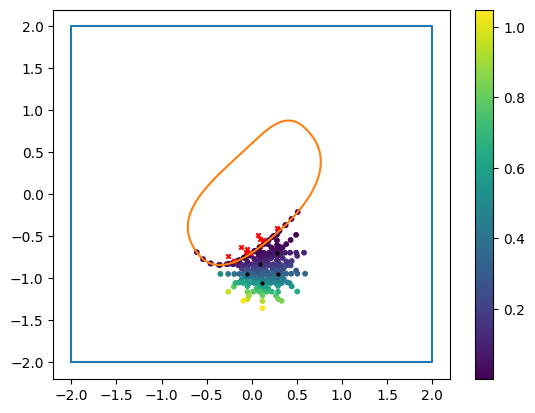

In [ ]:
nodesCurves = data[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

nodes_in = nodesTP_BEi[bTP_BEi]
nodes_out = nodesTP_BEi[~bTP_BEi]
u_in = uTP_BEi[bTP_BEi]
u_out = uTP_BEi[~bTP_BEi]
x = np.concatenate([nodes_in[:,0],nodesTP_BEb[:,:,0].flatten()])
y = np.concatenate([nodes_in[:,1],nodesTP_BEb[:,:,1].flatten()])
u = np.concatenate([u_in[:,:],uTP_BEb[:,:,:].reshape(-1,3)],0)

# plt.scatter(nodes_in[:,0],nodes_in[:,1],c=u_in[:,2])
# plt.colorbar()
# plt.scatter(nodesTP_BEb[:,:,0].flatten(),nodesTP_BEb[:,:,1].flatten(),c=uTP_BEb[:,:,0])
plt.scatter(x,y,c=u[:,0],s=10)
plt.colorbar()
plt.scatter(nodes_out[:,0],nodes_out[:,1],c='r', marker='x',s=10)
plt.scatter(nodesTPB[:,0],nodesTPB[:,1],c='k',s=4)

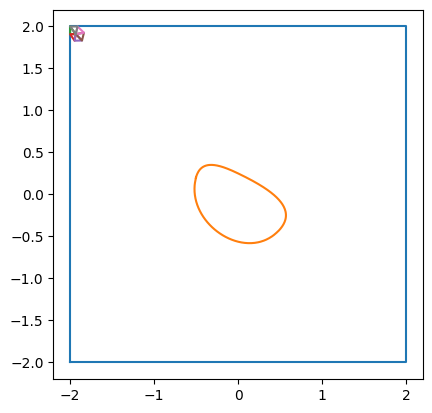

In [ ]:
def GenerateTriangTrainMeshCorner(v_rand = 0.1):
    # Generates a mesh of 6 triangular elements in a hexagon configuration where the 3 nodes in the left bottom corner have coordinates (0,1), (0,0) and (1,0)
    sqrt_2 = np.sqrt(2)
    nodes = np.array([[(sqrt_2+1)/(2*sqrt_2), (sqrt_2+1)/(2*sqrt_2)],
                      [0,0],
                      [1,0],
                      [1+1/sqrt_2,1/sqrt_2],
                      [1+1/sqrt_2,1+1/sqrt_2],
                      [1/sqrt_2,1+1/sqrt_2],
                      [0,1]])
    
    nodes[[0,3,4,5]] += np.random.uniform(-v_rand,v_rand,(4,2))

    elements = np.arange(3).reshape(1,-1)+np.arange(6).reshape(-1,1)
    elements[:,0] = 0
    elements[elements>6]=1
    return nodes,elements

def GetRandomTPmeshCorner(distaceCornerCurve,idxCurveCorner,interpNodesB,IsInDomainF,elSizeMin=0.04,elSizeMax=0.07,idx_corner=None):
    # Get a random boundary training patch mesh (nodesTPB, elementsTPB) from a mesh defined by (nodesB, alpha)
    #   nodesB - [N,2] tensor which contains the x,y coordinates of the boundary nodes

    if idx_corner is None:
        idx_corner = np.random.randint(0,len(distaceCornerCurve))
    
    idx_curve = idxCurveCorner[idx_corner]
    distance_1 = distaceCornerCurve[idx_corner] # distance along the boundary of the node[1]

    iterations = 0

    while iterations < 1_000:

        elSize1 = np.random.uniform(elSizeMin,elSizeMax) # define the element size of the training patch mesh
        elSize2 = np.random.uniform(elSize1*0.8,elSize1*1.2) # define the element size of the training patch mesh
        distance_2 = (distance_1 + elSize1) # distance along the boundary of the node[2]
        distance_6 = (distance_1 - elSize2) # distance along the boundary of the node[6]


        # interpolate the boundary nodes
        nodes_1 = interpNodesB[idx_curve](distance_1)
        nodes_2 = interpNodesB[idx_curve](distance_2)
        nodes_6 = interpNodesB[idx_curve](distance_6)

        # compute the transformation matrix
        R = np.stack([nodes_2-nodes_1,nodes_6-nodes_1],1)

        # generate the training patch mesh and transform it so that fits the corner
        nodesTPC, elementsTPC = GenerateTriangTrainMeshCorner(0.2)
        nodesTPC = (R@nodesTPC.T).T + nodes_1
        isInDomain = IsInDomainF(nodesTPC[[0,3,4,5]])
        # break
        if np.all(isInDomain):
            break
        iterations += 1
        print(iterations)

    # print(iterations)
    return nodesTPC, elementsTPC, distance_1, distance_2, distance_6, idx_curve

def GetRandomTrainingPatchCorner(data, nodesIE, distanceBE, nodesD, elSizeMin=0.04, elSizeMax=0.07, debugging=False):
    # Samples a random boundary training patch (2 nodes lie on the boundary) from the dataset of solutions and generates all the relevent outputs
    #   data - list of dictionaries which defines dataset of solutions
    #   nodesIE - interior encoder input mask nodes
    #   s_alphaBE - boundary encoder input mask nodes (defined as distance along the boundary)
    #   elSizeMin, elSizeMax - approximate min, max size of the logest edge in the training patch mesh
    idx = np.random.randint(len(data))

    distaceCornerCurve = data[idx]['distaceCornerCurve']
    idxCurveCorner = data[idx]['idxCurveCorner']
    interpNodesB = data[idx]['interpBC']
    IsInDomainF = data[idx]['isInDomainF']
    nodesTPC, elementsTPC, distance_1, distance_2, distance_6, idx_curve = GetRandomTPmeshCorner(distaceCornerCurve,idxCurveCorner,interpNodesB,IsInDomainF,elSizeMin,elSizeMax)

    # Get interior encoder and boundary encoder intpus
    #  interiour encoder inputs: uTP_BEi (physical variabel u values), bTP_BEi (is inside the domain)
    #  boundary encoder inputs: uTP_BEb (physical variabel u values), normalTP_BEb (normal vector of the boundary)
    interpSE = data[idx]['interpSE']
    interpSD = data[idx]['interpSD']
    interpBS = data[idx]['interpBS'][idx_curve]
    interpBN = data[idx]['interpBN'][idx_curve]

    nodesTP_CEi = GetEncoderInputTP(nodesTPC[[0,3,4,5]],nodesIE) # get nodes for the interour encoder input
    uTP_CEi = interpSE(nodesTP_CEi.reshape(-1,2)).reshape(nodesTP_CEi.shape[0],nodesTP_CEi.shape[1],-1)
    bTP_CEi = isInDomainF(nodesTP_CEi.reshape(-1,2)).reshape(nodesTP_CEi.shape[0],nodesTP_CEi.shape[1])
    uTP_CEi[~bTP_CEi] = 0
    bTP_CEi = np.expand_dims(bTP_CEi,-1)
    distanceTP_CEb = np.array([[distance_1],[distance_2],[distance_6]])+distanceBE # get alpha for the boundary encoder input
    uTP_CEb = interpBS(distanceTP_CEb)
    normalTP_CEb = interpBN(distanceTP_CEb)

    nodesTP_D = nodesD+nodesTPC[:1,:]
    u_D = interpSD(nodesTP_D) # sample solution at decoder output mask nodes
    b_D = isInDomainF(nodesTP_D) # sample boundary mask for decoder output (1 if inside the domain, 0 if outside)
    u_D[~b_D] = 0 # set solution values outside of the domain to 0

    if debugging:
        interpBC = data[idx]['interpBC'][idx_curve]
        nodesTP_CEb = interpBC(distanceTP_CEb)
        return nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D, nodesTP_CEi, nodesTP_CEb
    else:
        return nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D

distaceCornerCurve = data[0]['distaceCornerCurve']
idxCurveCorner = data[0]['idxCurveCorner']
interpNodesB = data[0]['interpBC']
IsInDomainF = data[0]['isInDomainF']
nodesTPC, elementsTPC, distance_1, distance_2, distance_6, idx_curve = GetRandomTPmeshCorner(distaceCornerCurve,idxCurveCorner,interpNodesB,IsInDomainF,elSizeMin=0.1,elSizeMax=0.2,idx_corner=None)

nodesCurves = data[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

for el in elementsTPC:
    plt.plot(nodesTPC[el[[0,1,2,0]],0],nodesTPC[el[[0,1,2,0]],1])

plt.gca().set_aspect('equal', adjustable='box')


(1.090181834096221, 2.309648292034183)

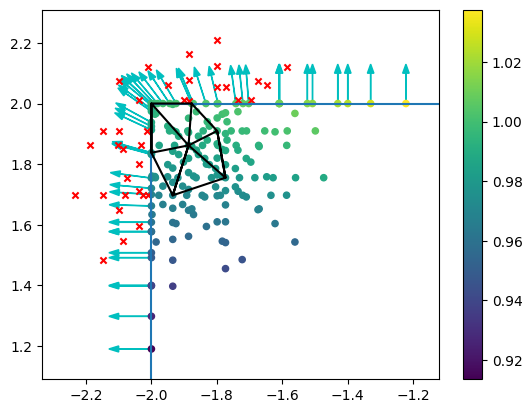

In [ ]:
data_i = data[100:101]
nodesIE = GetRadialEncoderInputMask(5,8,0.7,0.3)
nodesD = GetRadialEncoderInputMask(0,0)
distanceBE = GetBoundaryEncoderInputMask(8,0.7,0.6)

elSizeMin = 0.2
elSizeMax = 0.21
debugging = True

nodesTPC, elementsTPC, uTP_CEi, bTP_CEi, uTP_CEb, normalTP_CEb, u_D, b_D, nodesTP_CEi, nodesTP_CEb = GetRandomTrainingPatchCorner(data_i, nodesIE, distanceBE, nodesD, elSizeMin, elSizeMax, debugging)


nodesCurves = data[0]['nodesCurves']
for i in range(len(nodesCurves)):
    plt.plot(nodesCurves[i][:,0],nodesCurves[i][:,1])

nodes_in = nodesTP_CEi[bTP_CEi[...,0]]
nodes_out = nodesTP_CEi[~bTP_CEi[...,0]]
u_in = uTP_CEi[bTP_CEi[...,0]]
u_out = uTP_CEi[~bTP_CEi[...,0]]
x = np.concatenate([nodes_in[:,0],nodesTP_CEb[:,:,0].flatten()])
y = np.concatenate([nodes_in[:,1],nodesTP_CEb[:,:,1].flatten()])
u = np.concatenate([u_in[:,:],uTP_CEb[:,:,:].reshape(-1,3)],0)

arrow_length = 0.1
for i in range(normalTP_CEb.shape[0]):
    for j in range(normalTP_CEb.shape[1]):
        plt.arrow(nodesTP_CEb[i,j,0],nodesTP_CEb[i,j,1],normalTP_CEb[i,j,0]*arrow_length,normalTP_CEb[i,j,1]*arrow_length,head_width=0.02, color='c')

plt.scatter(x,y,c=u[:,0],s=20)
plt.colorbar()
plt.scatter(nodes_out[:,0],nodes_out[:,1],c='r', marker='x',s=20)
idx_mesh = [6,1,2,3,4,5,6,0,1,2,0,3,0,4,5,0]
plt.plot(nodesTPC[idx_mesh,0],nodesTPC[idx_mesh,1],c='k')


x_max = max(nodesTP_CEi[:,:,0].max(),nodesTP_CEb[:,:,0].max())+0.1
x_min = min(nodesTP_CEi[:,:,0].min(),nodesTP_CEb[:,:,0].min())-0.1
y_max = max(nodesTP_CEi[:,:,1].max(),nodesTP_CEb[:,:,1].max())+0.1
y_min = min(nodesTP_CEi[:,:,1].min(),nodesTP_CEb[:,:,1].min())-0.1
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)